<a href="https://colab.research.google.com/github/eunewoo/dlatk-for-nocoder/blob/main/Copy_of_Copy_of_Practice_of_DLATK2_2_Colab_Tutorial_for_Differential_Language_Analysis_(Getting_Started).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> DLATK - Colab Tutorial for Differential Language Analysis </h1>

This tutorial covers:

<img src="https://drive.google.com/uc?export=view&id=16SgSLj9KkmxUX8LEeFNsq0GRE4gqvQux" height="170"/>

# STEP1: Setup Colab


In [ ]:
#@markdown Click the __Play button__ to the left to start the setup. Proceed to the next stage once you see:

#@markdown "DLATK setup completed successfully. Enjoy your analysis!"

from IPython.utils import io
import subprocess

# Additional components to allow continuation into text and ID column selection and feature extraction
text_column_name = None
id_column_name = None

def setup_dlatk():
    # Install DLATK with additional features
    subprocess.run("pip install dlatk[wordcloud,langid]", shell=True)

    # Initialize DLATK for Colab environment
    result = subprocess.run("dlatkInterface.py --colabify", shell=True, capture_output=True, text=True)

    # Optional: Adjust Colab output for a better experience
    try:
        from dlatk.tools.colab_methods import colab_shorten_and_bg
        colab_shorten_and_bg()  # This shortens output blocks and changes the output background color.
    except ImportError as e:
        print("Some optional setup steps failed:", e)

    return result.stdout + '\n' + result.stderr

# Suppressing the output of the main installation and setup commands
with io.capture_output() as captured:
    setup_output = setup_dlatk()

# Check the captured output for a specific success message
if 'DLATK exits with success! A good day indeed' in setup_output:
    print("DLATK setup completed successfully. Enjoy your analysis!")
else:
    print("DLATK setup may have encountered issues. Please check the logs for more details.")


<IPython.core.display.Javascript object>

DLATK setup completed successfully. Enjoy your analysis!


In [ ]:
import re
from google.colab import files
import os
import csv

#@title Upload text data
#@markdown ### Select text Dataset or Upload from Desktop
#@markdown Choose a text dataset from the dropdown, or select "Upload from desktop" to upload your own file.

#@markdown After making your selection, click the __play button__ at the top left to proceed.

text_filename = "msgs404u.csv" #@param ["Upload from desktop", "msgs404u.csv"]

#@markdown If "Upload from desktop" is selected, then click the __"Choose Files"__ button at the bottom to upload your file.

def sanitize_file_name(file_name):
    base_file_name = re.sub(r" \(\d+\)", "", file_name)
    if not base_file_name.endswith('.csv'):
        base_file_name += '.csv'
    return base_file_name

# def add_message_id_if_missing(file_path):
#     headers_changed = False
#     with open(file_path, mode='r', encoding='utf-8') as file:
#         reader = csv.reader(file)
#         headers = next(reader, None)

#         if headers and 'message_id' not in headers:
#             headers_changed = True
#             new_rows = [['message_id'] + headers]
#             new_rows += [[str(i+1)] + row for i, row in enumerate(reader)]

#     if headers_changed:
#         with open(file_path, mode='w', encoding='utf-8', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerows(new_rows)
#         print("Added 'message_id' column and saved changes.")
#     else:
#         print("'message_id' column already exists.")

    #return new_rows

if text_filename != "Upload from desktop":
    file_name = sanitize_file_name(text_filename)
    file_path = os.path.join("/content", file_name)
    print(f'Text file selected: {file_name}')
else:
    print("Please upload a file from the desktop.")
    uploaded_files = files.upload()
    if uploaded_files:
        file_name = next(iter(uploaded_files))
        file_name = sanitize_file_name(file_name)
        file_path = os.path.join("/content", file_name)
        #headers = add_message_id_if_missing(file_path)
        # add_message_id_if_missing(file_path)
        print(f'Uploaded file name: {file_name}')
    else:
        print("No file uploaded. Please upload a file to proceed.")

if os.path.exists(file_path):
    print(f'File ready for use: {file_path}')
else:
    print("File not found. Please ensure the file exists and try again.")


<IPython.core.display.Javascript object>

Text file selected: msgs404u.csv
File ready for use: /content/msgs404u.csv


<a name="data"></a>
# STEP2: Upload text data & Select text column

DLATK uses data in CSV (comma-seprated value) format. Your csv needs at least two columns:
* **`message`**: contains the text to be analyzed.
* **`user_id`**: contains a user id for each message.

<br />

The CSV may also have other columns, including other ids you may wish to analyze your data by (e.g. `message_id`). For example,

|message_id|message|user_id|created_date|
|----------|-------|-------|------------|
|17557|urlLink Ananova - New rules on pizza to be introduced|1405024|2004-05-27|
|15996|I just read John Kerry's nomination acceptance speech. Christ, he can talk.  God bless America.|3523319|2004-07-29|
|27462| Talk about 'better late than never'...   urlLink  Couple Living Together 77 Years Marries   .   Thanks to  urlLink  Zorak  for the link.|942828|2003-04-04|

<br />
<br />



* `Upload from desktop` - your csv data that you want to analyze.
* `msgs404u.csv` - sample language data from 404 blog authors.
<!-- * `msgs100u.csv` - sample language data from 100 blog authors. -->

<br />

In [ ]:
#@title Select Text Column (unit of analysis)

#@markdown Click the __play button__ at the top left to view the dropdown menu.

#@markdown __Select__ the Text Column you wish to analyze, then click the "Run Command" button.

import csv
import ipywidgets as widgets
from IPython.display import display, clear_output

def get_available_columns(file_path):
    """Read the first row of the CSV file to get the column names."""
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        headers = next(reader, None)
    return headers

available_columns = get_available_columns(file_path)

text_column_options = [col for col in available_columns if col != "user" and not col.endswith("_id")]
text_column_dropdown = widgets.Dropdown(options=text_column_options, description='Text Column:')
text_confirm_button = widgets.Button(description="Confirm Text Column")
output = widgets.Output()

def on_text_confirm_button_clicked(b):
    global text_column_name
    text_column_name = text_column_dropdown.value
    with output:
        clear_output()
        print(f'Text Column confirmed: {text_column_name}')
        # Now you should run the next code block to select the ID column

text_confirm_button.on_click(on_text_confirm_button_clicked)
display(text_column_dropdown, text_confirm_button, output)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Text Column:', options=('created_date', 'message'), value='created_date')

Button(description='Confirm Text Column', style=ButtonStyle())

Output()

In [ ]:
#@title Select ID Column (unit of analysis)

#@markdown Click the __play button__ at the top left to view the dropdown menu.

#@markdown __Select__ the ID Column you wish to analyze, then click the "Confirm ID Column" button.

import csv
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assuming 'file_path' is defined and accessible
# Assuming 'text_column_name' is defined and accessible (selected from Code A)

def get_available_columns(file_path):
    """Read the first row of the CSV file to get the column names."""
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        headers = next(reader, None)
    return headers

def add_id_column_if_missing(file_path, column_name):
    """Adds an ID column if it's missing, appending numbers from 1 upwards to the end of each row."""
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = list(csv.reader(file))
        headers = reader[0]
        column_id_name = column_name + '_id'
        if column_id_name not in headers:
            headers.append(column_id_name)  # Append the new ID column name to the headers
            for i, row in enumerate(reader[1:], start=1):  # Start from 1 to skip header row
                row.append(str(i))  # Append the new ID value at the end of each row
            with open(file_path, mode='w', encoding='utf-8', newline='') as wfile:
                writer = csv.writer(wfile)
                writer.writerow(headers)  # Write the updated headers
                writer.writerows(reader[1:])  # Write the updated data rows, excluding the original headers
            print(f"Added '{column_id_name}' column and saved changes.")
            return True
    return False

# Attempt to add an ID column if missing
add_id_column_if_missing(file_path, text_column_name)

# Refresh available columns to include potential new ID column
available_columns = get_available_columns(file_path)

# Include all columns ending with "_id" and the new ID column related to the selected text column
id_column_options = [col for col in available_columns if col.endswith("_id")]

id_column_dropdown = widgets.Dropdown(options=id_column_options, description='ID Column:', value=None)
id_confirm_button = widgets.Button(description="Confirm ID Column")
output = widgets.Output()

def on_id_confirm_button_clicked(b):
    global id_column_name
    id_column_name = id_column_dropdown.value
    with output:
        clear_output()
        print(f'ID Column confirmed: {id_column_name}')

id_confirm_button.on_click(on_id_confirm_button_clicked)
display(id_column_dropdown, id_confirm_button, output)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='ID Column:', options=('message_id', 'user_id'), value=None)

Button(description='Confirm ID Column', style=ButtonStyle())

Output()

👉 For detailed information about the columns in the `msgs404u.csv` file, as well as their corresponding outcome files `users404.csv`, you can refer to [this link](https://github.com/dlatk/dlatk/blob/public/dlatk/data/colab_dataset.md). This link contains detailed descriptions of what each column in these datasets represents.

<a name="data"></a>
# STEP3: Select features to extract & Check tables

In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output

#@title Select features to extract
#@markdown Click the __play button__ at the top left to view the dropdown menu.

#@markdown __Select__ the features you wish to analyze, then click the "Run Command" button.

database_name = "colab_csv"
file_name_without_extension = file_name.rsplit('.', 1)[0]  # Assuming file_name is defined globally

# Dropdown for feature generation options
feature_options = widgets.Dropdown(
    options=['Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'topics'],
    value='Select option',
    description='Options:',
)

# Integer input for advanced topic modeling, hidden by default
advanced_options = widgets.IntText(
    value=100,
    description='Group Freq Thresh:',
    style={'description_width': 'initial'},
    disabled=False,  # Enable by default but hidden
    layout={'visibility': 'hidden'}  # Start with hidden layout
)

# Text area for displaying output
output = widgets.Output()
run_button = widgets.Button(description="Run Command")

def generate_unfiltered_feature_table():
    global generated_feature_table_name
    combined_feature_table_name = "1to2gram"
    command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
              f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
              f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name}"
    print(f"Generating unfiltered 1to2grams feature table: {command}")
    subprocess.run(command, shell=True)
    generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}"
    print(f"Generated feature table: {generated_feature_table_name}")

def execute_feature_command(b):
    global generated_feature_table_name
    group_freq_thresh = advanced_options.value if feature_options.value == 'topics' else 100

    with output:
        clear_output()
        if feature_options.value == '1to2grams-unfiltered':
            generate_unfiltered_feature_table()

        elif feature_options.value == '1to2grams-filtered':
            combined_feature_table_name = "1to2gram"
            command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                      f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                      f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name} " \
                      f"--feat_occ_filter --set_p_occ 0.10 --feat_colloc_filter"
            print(f"Executing: {command}")
            subprocess.run(command, shell=True)
            generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}$0_1$pmi3_0"
            print(f"Generated feature table: {generated_feature_table_name}")

        elif feature_options.value == 'topics':
            lex_table_name = f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"
            command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                      f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                      f"--group_freq_thresh {group_freq_thresh} --add_lex_table -l fb2000_cp --weighted_lexicon"
            print(f"Executing: {command}")
            subprocess.run(command, shell=True)
            print(f"Generated LDA feature table: {lex_table_name}")

def on_feature_change(change):
    if change['new'] == 'topics':
        advanced_options.layout.visibility = 'visible'  # Make visible
    else:
        advanced_options.layout.visibility = 'hidden'  # Hide
        advanced_options.value = 100  # Reset to default when not on 'topics'

feature_options.observe(on_feature_change, names='value')

run_button.on_click(execute_feature_command)
display(feature_options, advanced_options, run_button, output)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Options:', options=('Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'topi…

IntText(value=100, description='Group Freq Thresh:', layout=Layout(visibility='hidden'), style=DescriptionStyl…

Button(description='Run Command', style=ButtonStyle())

Output()

In [ ]:
#@markdown Test code: Check which tables are formed so far

!dlatkInterface.py \
  -d colab_csv -t msgs404u.csv -g message_id \
  --show_feat_tables

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-05 02:33:57
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db

Found 3 available tables
----
feat$cat_fb2000_cp_w$msgs404u$message_id$1gra
feat$1gram$msgs404u$message_id
feat$meta_1gram$msgs404u$message_id
-------
Settings:

Database - colab_csv
Corpus - msgs404u.csv
Group ID - message_id
-------
Interface Runtime: 0.01 seconds
DLATK exits with success! A good day indeed  ¯\_(ツ)_/¯.


In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output

#@title Feature Tables Management { display-mode: "form" }
#@markdown **Click the play button** to display feature tables from your previously uploaded file, save your selections, and view a specific table.

#@markdown After making a selection, the first 10 rows of the chosen feature table will be displayed within 3 seconds.



# Mapping of user-friendly option names to their corresponding command strings
feature_table_mapping = {
    "1to2grams-filtered-table": f"feat$1to2gram${file_name_without_extension}${id_column_name}$0_1$pmi3_0",
    "1to2grams-unfiltered-table": f"feat$1to2gram${file_name_without_extension}${id_column_name}",
    "topics-table": f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"  # Adding topics-related feature table option
}

# Create a dropdown for selecting the feature table using the friendly names
dropdown = widgets.Dropdown(
    options=[(key, value) for key, value in feature_table_mapping.items()],
    description='Select Table:',
    style={'description_width': 'initial'}
)

# Text area for displaying output
output_text_area = widgets.Output()

# Button to execute the command for the selected feature table
run_command_button = widgets.Button(description="Run Command")

def run_command(b):
    selected_table = dropdown.value  # This gets the actual command string from the mapping
    # Surround the selected_table with single quotes for the command
    command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} -f '{selected_table}' --view_tables"
    process = subprocess.run(command, shell=True, capture_output=True, text=True)
    with output_text_area:
        clear_output(wait=True)  # Optionally clear previous output
        if process.stdout:
            print("Command Output:\n", process.stdout)
        if process.stderr:
            print("Command Error:\n", process.stderr)

# Attach the button click event to the run_command function
run_command_button.on_click(run_command)

# Display UI components
display(dropdown, run_command_button, output_text_area)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Select Table:', options=(('1to2grams-filtered-table', 'feat$1to2gram$msgs404u$message_id…

Button(description='Run Command', style=ButtonStyle())

Output()

<a name="data"></a>
# STEP4: Correlate outcome

Now that you have the language features, you can correlate them against outcomes like `age` while controlling for another variable like `gender`.


<img src="https://drive.google.com/uc?export=view&id=11ODkDFwsfQFc-5R5o757k3Ij9XbW9_Yb" height="250" width="500"/>

<br/>

To do this, you need to tell DLATK the feature table to use and the outcomes:

* **`-f 'TABLE_NAME'`** - names of the feature table (`feat$1to2gram$msgs404u$user_id$0_2$pmi3_0` in this case)
* **`--outcome_table NAME`** - the name of the table with outcomes (`users404.csv`, can be the message table if it contains the outcomes)
* **`--outcomes OC1 [OC2...]`** - list of outcomes to be associated with (`age` in this case)
* **`--controls C1 [C2...]`** - list of statistical controls for the ascociation (we will control for `gender` in this example).

<br/>

Then, you specify what that you want a correlation matrix output with **`--rmatrix`** flag, and because the `gender` variable is categorical, we
 **`--cat_to_bin gender`** which converts the variable into [one-hot representation](https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-One-Hot-Encoding-Improves-Machine-Learning-Performance--VmlldzoxOTkzMDk).


In [ ]:
import re
from google.colab import files
import os

#@title Upload correlate data

#@markdown Select a predefined dataset from the dropdown menu, or choose "Upload from desktop" to upload your own dataset.

# This is a dropdown for choosing between default datasets or uploading your own
default_dataset = "users404.csv" #@param ["Upload from desktop", "users404.csv"]

#@markdown If you opt for desktop upload, click the "Choose Files" button that appears upon executing this cell.

# Function to check if the file exists (for local files)
def file_exists(file_path):
    return os.path.exists(file_path)

# Sanitizes file names to ensure they end with '.csv'
def sanitize_file_name(file_name):
    base_file_name = re.sub(r" \(\d+\)", "", file_name)
    if not base_file_name.endswith('.csv'):
        base_file_name += '.csv'
    return base_file_name

file_path = None  # Initialize file_path variable

if default_dataset != "Upload from desktop":
    # If a default dataset is selected, set the file_path accordingly
    outcome_table_name = sanitize_file_name(default_dataset)
    file_path = os.path.join("/content", outcome_table_name)
    print(f'Default dataset selected: {outcome_table_name}')
else:
    print("Please upload a dataset from the desktop.")
    uploaded_files = files.upload()
    if uploaded_files:
        # Assuming only one file is uploaded, use its name
        filename = next(iter(uploaded_files))
        outcome_table_name = sanitize_file_name(filename)  # Sanitize the uploaded file's name
        file_path = os.path.join("/content", outcome_table_name)
        print(f'Uploaded dataset name: {outcome_table_name}')
    else:
        print("No dataset uploaded. Please upload a dataset to proceed.")

# Verify the file's existence and readiness for use
if file_path and file_exists(file_path):
    print(f'Dataset ready for use: {file_path}')
else:
    print("Dataset not found. Please ensure the dataset exists and try again.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Default dataset selected: users404.csv
Dataset ready for use: /content/users404.csv


In [ ]:
#@title shashanka cloud
!dlatkInterface.py -d colab_csv -t msgs404u.csv -g message_id --message_field message --group_freq_thresh 100 --add_ngrams -n 1 --feat_occ_filter --set_p_occ 3



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-08 21:45:30
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
query: PRAGMA table_info(msgs404u)
SQL Query: DROP TABLE IF EXISTS feat$1gram$msgs404u$message_id
SQL Query: CREATE TABLE feat$1gram$msgs404u$message_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(36), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$1gram$msgs404u$message_id, column:group_id 


SQL Query: CREATE INDEX correl_field$1gram$msgs404u$message_id ON feat$1gram$msgs404u$message_id (group_id)


Creating index feature on table:feat$1gram$msgs404u$message_id, column:feat 


SQL Query: CREATE INDEX feature$1gram$msgs404u$message_id ON feat$1gram$msgs404u$message_id (feat)
query: PRAGMA table_info(msgs404u)
SQL Query: DROP TABLE IF EXISTS feat$meta_1gram$msgs404u$message_id
SQL Query: CREATE TABLE feat$meta_1gram$msgs404u$message_id ( id INTE

In [ ]:
!dlatkInterface.py -d colab_csv -t msgs404u.csv -g user_id --group_freq_thresh 100 -f 'feat$1gram$msgs404u$user_id$3_0' --add_lex -l fb2000_cp --weighted_lex

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-08 21:46:57
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
query: PRAGMA table_info(msgs404u)
SQL Query: DROP TABLE IF EXISTS feat$cat_fb2000_cp_w$msgs404u$user_id$1gra
SQL Query: CREATE TABLE feat$cat_fb2000_cp_w$msgs404u$user_id$1gra ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(10), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$cat_fb2000_cp_w$msgs404u$user_id$1gra, column:group_id 


SQL Query: CREATE INDEX correl_field$cat_fb2000_cp_w$msgs404u$user_id$1gra ON feat$cat_fb2000_cp_w$msgs404u$user_id$1gra (group_id)


Creating index feature on table:feat$cat_fb2000_cp_w$msgs404u$user_id$1gra, column:feat 


SQL Query: CREATE INDEX feature$cat_fb2000_cp_w$msgs404u$user_id$1gra ON feat$cat_fb2000_cp_w$msgs404u$user_id$1gra (feat)
WORD TABLE feat$1gram$msgs404u$user_id
4 out of 404 group Id's processed; 0.

In [ ]:
!dlatkInterface.py -d colab_csv -t msgs404u.csv -g user_id --group_freq_thresh 50 -f 'feat$cat_fb2000_cp_w$msgs404u$user_id$1gra' --outcome_table users404.csv --outcomes age --controls gender --cat_to_bin gender --make_topic_wordclouds --topic_lexicon fb2000_freq_t50ll

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-13 21:02:57
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
SQL Query: CREATE TABLE users404 (user_id INT, gender INT, age INT, occu VARCHAR(23), is_student DOUBLE);
Importing data, reading users404.csv file
Reading remaining 404 rows into the table...
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Loading Outcomes and Getting Groups for: {'age', 'gender'}
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Yielding data over ['age'], adjusting for: ['gender__0'].
Yielding norms with zeros (404 groups * 2001 feats).
                                 OLS Regression Results                                
Dep. Variable:                    age   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IndexError: index 2 is out of bounds for axis 0 with size 2

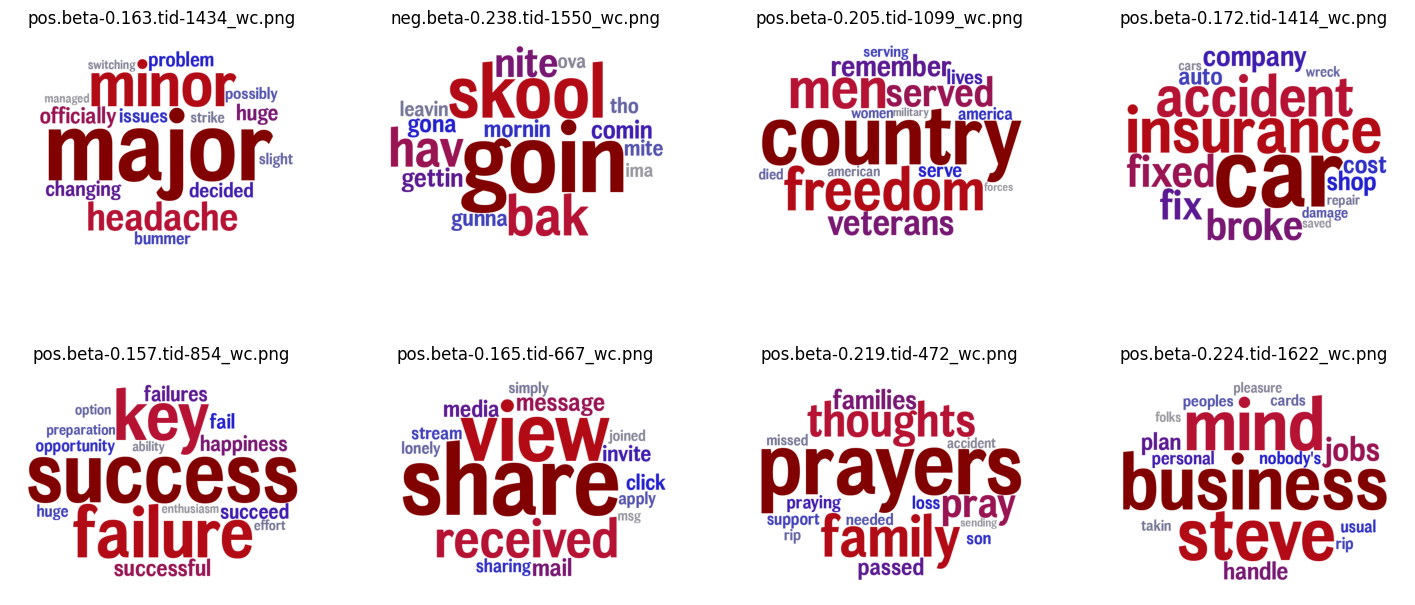

In [ ]:
import glob
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def print_topic_wordclouds(
    wordcloud_folder,
    num_topics=8,
    images_per_row=4):

    images = glob.glob(os.path.join(wordcloud_folder, '*.png'))
    to_display = images[:min(num_topics, len(images))]

    fig, axes = plt.subplots(math.ceil(num_topics/images_per_row), images_per_row, figsize=(18, 8))
    for index, image in enumerate(images):

        axes[int(index/images_per_row), index%images_per_row].set_axis_off()
        axes[int(index/images_per_row), index%images_per_row].set_title(image.split('/')[-1])
        axes[int(index/images_per_row), index%images_per_row].imshow(mpimg.imread(image))

    return

print_topic_wordclouds("./feat.cat_fb2000_cp_w.msgs404u.user_id.1gra.age.gender__0.freq50._topic_tagcloud_wordclouds/age")

In [ ]:
!dlatkInterface.py -d colab_csv -t msgs404u.csv -g user_id --group_freq_thresh 50 -f 'feat$cat_fb2000_cp_w$msgs404u$user_id$1gra' --outcome_table users404.csv --outcomes age controls gender cat_to_bin gender --make_topic_wordclouds --topic_lexicon fb2000_freq_t50ll

In [ ]:
!dlatkInterface.py \
  -d colab_csv -t msgs404u.csv -g user_id \
  -f 'feat$cat_fb2000_cp_w$msgs404u$user_id$1gra' \
  --view_tables

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-08 18:29:53
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db

Printing: msgs404u
----

     message_id        user_id   created_date        message
          17236         174357     2004-06-28     You Are Ri
          17237         174357     2004-06-24     Im so tire
          17238         174357     2004-07-28     So I start
          25669         446275     2004-05-28     I just don
          25670         446275     2004-05-25     [this is a
          25671         446275     2004-05-24     Another th
          25672         446275     2004-05-16     I come bac
          25673         446275     2004-05-16     As any goo
          25674         446275     2004-05-15     A previous
          25675         446275     2004-05-15     If those h

Printing: feat$cat_fb2000_cp_w$msgs404u$user_id$1gra
----

             id       group_id           f

In [ ]:
#@markdown Test code: Check which tables are formed so far

!dlatkInterface.py \
  -d colab_csv -t msgs404u.csv -g user_id \
  --show_feat_tables

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-08 17:48:34
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db

Found 4 available tables
----
feat$1gram$msgs404u$user_id
feat$meta_1gram$msgs404u$user_id
feat$1gram$msgs404u$user_id$3_0
feat$cat_fb2000_cp_w$msgs404u$user_id$1gra
-------
Settings:

Database - colab_csv
Corpus - msgs404u.csv
Group ID - user_id
-------
Interface Runtime: 0.01 seconds
DLATK exits with success! A good day indeed  ¯\_(ツ)_/¯.


In [ ]:
#@markdown Topic wordcloud testing
# import MySQLdb


# dlatkInterface.py -d colab_csv -t msgs404u.csv -g message_id --message_field message --messageid_field message_id --group_freq_thresh 100 --add_lex_table -l fb2000_cp --weighted_lexicon

# !dlatkInterface.py \
#   -d colab_csv -t msgs404u.csv -g message_id \
#   --add_ngrams -n 1

# !dlatkInterface.py -d colab_csv -t msgs404u.csv -g user_id --lexicondb colab_csv --group_freq_thresh 100 --feat_table 'feat$1gram$msgs404u$user_id' --outcome_table users404.csv --outcomes age --controls gender --cat_to_bin gender --rmatrix --make_topic_wordclouds --topic_lexicon fb2000_freq_t50ll

# !dlatkInterface.py -d colab_csv -t msgs404u.csv -g message_id --lexicondb colab_csv --group_freq_thresh 100 --feat_table 'feat$1gram$msgs404u$message_id' --outcome_table users404.csv --rmatrix --make_topic_wordclouds --topic_lexicon fb2000_freq_t50ll



<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-06 17:19:23
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
query: PRAGMA table_info(msgs404u)
SQL Query: DROP TABLE IF EXISTS feat$1gram$msgs404u$message_id
SQL Query: CREATE TABLE feat$1gram$msgs404u$message_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(36), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$1gram$msgs404u$message_id, column:group_id 


SQL Query: CREATE INDEX correl_field$1gram$msgs404u$message_id ON feat$1gram$msgs404u$message_id (group_id)


Creating index feature on table:feat$1gram$msgs404u$message_id, column:feat 


SQL Query: CREATE INDEX feature$1gram$msgs404u$message_id ON feat$1gram$msgs404u$message_id (feat)
query: PRAGMA table_info(msgs404u)
SQL Query: DROP TABLE IF EXISTS feat$meta_1gram$msgs404u$message_id
SQL Query: CREATE TABLE feat$meta_1gram$msgs404u$message_id ( id INTE

In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv

#@title Configure Parameters

#@markdown Before executing the command, please adjust the parameters below according to your dataset and analysis needs.
database_name = "colab_csv"

feature_table_mapping = {
    "1to2grams-filtered-table": f"feat$1to2gram${file_name_without_extension}${id_column_name}$0_1$pmi3_0",
    "1to2grams-unfiltered-table": f"feat$1to2gram${file_name_without_extension}${id_column_name}",
    "topics-table": f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"  # Adding topics-related feature table option
}

if 'outcome_table_name' in globals():
    # Open and read the CSV file to extract column names
    with open(outcome_table_name, newline='') as csvfile:
        reader = csv.reader(csvfile)
        column_headers = next(reader, None)

    if column_headers:
        # Exclude columns containing '_id' from being displayed as checkboxes
        filtered_column_headers = [option for option in column_headers if "_id" not in option]

        feature_table_dropdown = widgets.Dropdown(options=feature_table_mapping, description='Feature Table:')

        outcomes_title = widgets.Label('Outcomes:')
        controls_title = widgets.Label('Controls:')
        outcomes_widgets = {}
        controls_widgets = {}
        outcomes_cat_widgets = {}
        controls_cat_widgets = {}

        # Create checkboxes for each column header
        for option in filtered_column_headers:
            outcomes_widgets[option] = widgets.Checkbox(description=option, value=False)
            controls_widgets[option] = widgets.Checkbox(description=option, value=False)
            # Replace RadioButtons with a single Checkbox for categorical selection
            outcomes_cat_widgets[option] = widgets.Checkbox(
                description='Is this variable Categorical?',
                value=False,
                layout={'width': 'max-content'},
                style={'description_width': 'initial'}
            )
            controls_cat_widgets[option] = widgets.Checkbox(
                description='Is this variable Categorical?',
                value=False,
                layout={'width': 'max-content'},
                style={'description_width': 'initial'}
            )
            outcomes_cat_widgets[option].layout.display = 'none'
            controls_cat_widgets[option].layout.display = 'none'

        def handle_checkbox_change(change):
            option = change.owner.description
            if change.owner in outcomes_widgets.values():
                controls_widgets[option].disabled = change.new
                outcomes_cat_widgets[option].layout.display = 'flex' if change.new else 'none'
            elif change.owner in controls_widgets.values():
                outcomes_widgets[option].disabled = change.new
                controls_cat_widgets[option].layout.display = 'flex' if change.new else 'none'

        for checkbox in outcomes_widgets.values():
            checkbox.observe(handle_checkbox_change, names='value')
        for checkbox in controls_widgets.values():
            checkbox.observe(handle_checkbox_change, names='value')

        def on_submit(change):
            global outcomes, controls
            clear_output(wait=True)
            outcomes = [k for k, v in outcomes_widgets.items() if v.value]
            controls = [k for k, v in controls_widgets.items() if v.value]
            cat_to_bin_outcomes = [k for k, v in outcomes_cat_widgets.items() if v.value]
            cat_to_bin_controls = [k for k, v in controls_cat_widgets.items() if v.value]

            feature_table_name = feature_table_dropdown.value
            make_wordclouds = make_wordclouds_checkbox.value

            # Construct the command dynamically based on selections
            cat_to_bin_parts = [','.join(cat_to_bin_outcomes), ','.join(cat_to_bin_controls)]
            cat_to_bin_parts = [part for part in cat_to_bin_parts if part]  # Remove empty strings
            cat_to_bin_cmd = f"--cat_to_bin {' '.join(cat_to_bin_parts)}" if cat_to_bin_parts else ""

            command = (
                f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                f"--group_freq_thresh 100 --feat_table '{feature_table_name}' "
                f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                f"--controls {','.join(controls)} {cat_to_bin_cmd} --rmatrix"
            )
            if make_wordclouds:
                if feature_table_name == feature_table_mapping['topics-table']:
                    command += " --make_topic_wordclouds"
                else:
                    command += " --make_wordclouds"
            print("Command to execute:", command)
            process = subprocess.run(command, shell=True, text=True, capture_output=True)
            print(process.stdout)
            if process.stderr:
                print("Error:", process.stderr)

        submit_button = widgets.Button(description="Submit")
        submit_button.on_click(on_submit)

        make_wordclouds_title = widgets.Label('Make Wordclouds:')
        make_wordclouds_checkbox = widgets.Checkbox(value=False, description='Enable Wordclouds')

        # Display the widgets
        display(feature_table_dropdown)
        display(outcomes_title)
        for option, checkbox in outcomes_widgets.items():
            display(widgets.HBox([checkbox, outcomes_cat_widgets[option]]))
        display(controls_title)
        for option, checkbox in controls_widgets.items():
            display(widgets.HBox([checkbox, controls_cat_widgets[option]]))
        display(make_wordclouds_title, make_wordclouds_checkbox, submit_button)

    else:
        print("Failed to read column names from the outcome table.")
else:
    print("Outcome table name not set. Please ensure a file is uploaded in Part 1.")


Command to execute: dlatkInterface.py -d colab_csv -t msgs404u.csv -g message_id --group_freq_thresh 100 --feat_table 'feat$cat_fb2000_cp_w$msgs404u$message_id$1gra' --outcome_table users404.csv --outcomes age --controls gender --cat_to_bin gender --rmatrix --make_topic_wordclouds


Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Connecting to SQLite database: /content/sqlite_data/colab_csv.db

Error: TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-06 17:42:18
-----
         Please check that all messages have a unique message_id, this can significantly impact all downstream analysis
Loading Outcomes and Getting Groups for: {'gender', 'age'}
 *Sqlite Corpus DB Error on SELECT message_id, gender FROM users404 WHERE gender IS NOT NULL:
no such column: message_id (1 attempt)
 *Sqlite Corpus DB Error on SELECT message_id, gender FROM users404 WHERE gender IS NOT NULL:
no such column: message_id (2 attempt)

In [ ]:
!dlatkInterface.py -d colab_csv -t msgs404u.csv -g message_id --group_freq_thresh 100 -f 'feat$cat_fb2000_cp_w$msgs404u$message_id$1gra' --outcome_table users404.csv --outcomes age --rmatrix --csv --make_topic_wordclouds --topic_lex fb2000_freq_t50ll

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-06 17:46:17
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
         Please check that all messages have a unique message_id, this can significantly impact all downstream analysis
Loading Outcomes and Getting Groups for: {'age'}
 *Sqlite Corpus DB Error on SELECT message_id, age FROM users404 WHERE age IS NOT NULL:
no such column: message_id (1 attempt)
 *Sqlite Corpus DB Error on SELECT message_id, age FROM users404 WHERE age IS NOT NULL:
no such column: message_id (2 attempt)
 *Sqlite Corpus DB Error on SELECT message_id, age FROM users404 WHERE age IS NOT NULL:
no such column: message_id (3 attempt)
 *Sqlite Corpus DB Error on SELECT message_id, age FROM users404 WHERE age IS NOT NULL:
no such column: message_id (4 attempt)
 *Sqlite Corpus DB Error on SELECT message_id, age FROM u

In [ ]:
import glob
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dlatk.tools.colab_methods import print_wordclouds

#@markdown Click the Play button to view the **word cloud image** of the analyzed file(includes topic wordcloud).


feature_table_name = feature_table_dropdown.value.replace('$', '.')

def display_wordclouds(feature_table_name, outcomes, controls):
    # This function decides which type of word clouds to display based on the feature table selected.
    if feature_table_name == feature_table_mapping['topics-table']:
        print_topic_wordclouds("/content/_alltopics/", 8)
    else:
        wordcloud_file_name = f"{feature_table_name.replace('$', '.')}.{','.join(outcomes)}.{','.join(controls)}__0.freq100._tagcloud_wordclouds"
        print("Wordcloud File Name:", wordcloud_file_name)
        print_wordclouds(wordcloud_file_name)

def print_topic_wordclouds(wordcloud_folder, num_topics=8, images_per_row=4):
    # This function handles the displaying of topic word clouds specifically.
    images = glob.glob(os.path.join(wordcloud_folder, '*.png'))
    to_display = images[:min(num_topics, len(images))]

    if len(to_display) == 0:
        print("No topic wordcloud images found in the specified folder.")
        return

    fig, axes = plt.subplots(math.ceil(num_topics / images_per_row), images_per_row, figsize=(18, 8))
    for index, image in enumerate(to_display):
        ax = axes[int(index / images_per_row), index % images_per_row]
        ax.set_axis_off()
        ax.set_title(image.split('/')[-1])
        ax.imshow(mpimg.imread(image))
    plt.show()

# Example usage:
display_wordclouds(feature_table_name, outcomes, controls)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Wordcloud File Name: feat.cat_fb2000_cp_w.msgs404u.user_id.1gra.age.gender__0.freq100._tagcloud_wordclouds
None of the features were significant, hence wordclouds not produced.


In [ ]:
#@markdown Click the Play button to view the **word cloud image** of the analyzed file.

from dlatk.tools.colab_methods import print_wordclouds

def display_wordclouds():
    feature_table_name = feature_table_dropdown.value.replace('$', '.')
    # Assuming 'outcomes' and 'controls' are updated in the global scope by codeA
    global outcomes, controls
    wordcloud_file_name = f"{feature_table_name}.{','.join(outcomes)}.{','.join(controls)}__0.freq100._tagcloud_wordclouds"
    print("Wordcloud File Name:", wordcloud_file_name)
    print_wordclouds(wordcloud_file_name)

display_wordclouds()


<IPython.core.display.Javascript object>

Wordcloud File Name: feat.cat_fb2000_cp_w.msgs404u.user_id.1gra.age.gender__0.freq100._tagcloud_wordclouds
None of the features were significant, hence wordclouds not produced.


👇 For example, you can extract features from *NRC sentiment* dictionary as shown below.

# Running Prediction (Language-based Assessment)

<img src="https://drive.google.com/uc?export=view&id=1AgMttURoLyJZ6WhL9wnVzWBt1gSmE0yE" height="350" width="550"/>

## Prediction: Example 1: N-Fold Cross Validation

There are two types of [prediction models](https://scikit-learn.org/stable/modules/linear_model.html#) we can run:
1. **Regression**, which is the prediction of a continous variable, and
2. **Classification**, which is the prediction of a categorical variable.

<br/>

<hr/>

[N-Fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#) - This method involves randomly dividing the dataset into *N* groups, or "folds", of approximately equal size. The model is later fit on the N-1 folds (*train* data) and the evaluated for accuracy over the remaining one fold (*test* data).

<hr/>

<br/>

For running a prediction model against an outcome, you use the same data setup commands as in correlations:
* **`-f FEAT_TABLE_NAME`** - names of the feature table.
* **`--outcome_table NAME`** - the name of the table with outcomes.
* **`--outcomes OC1 [OC2...]`** - list of outcomes to predict.


### N-Fold Regression:


Below are the flags to perform regression using cross-validation:
* **`--nfold_test_regression`** - this activates regression using n-fold cross-validation.
* **`--model MODEL_NAME`** - which regression model to use (some examples would be ordinary least sqaures, ridge regression, etc.)

👇 For example, below command will predict `age` from 1gram and 2grams features using a ridge regression model over `5` fold cross validation.

In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv

#@title Configure Parameters

#@markdown Before executing the command, please adjust the parameters below according to your dataset and analysis needs.

if 'outcome_table_name' in globals():
    # Open and read the CSV file to extract column names
    with open(outcome_table_name, newline='') as csvfile:
        reader = csv.reader(csvfile)
        column_headers = next(reader, None)

    if column_headers:
        # Exclude columns containing '_id' from being displayed as checkboxes
        filtered_column_headers = [option for option in column_headers if "_id" not in option]

        feature_table_dropdown = widgets.Dropdown(options=feature_table_mapping, description='Feature Table:')

        # Dropdown for model selection
        model_dropdown = widgets.Dropdown(
            options=[
                'lasso', 'lassocv', 'elasticnet', 'elasticnetcv', 'lassolars', 'lassolarscv', 'lars', 'ridge',
                'ridge.01', 'ridge.001', 'ridge250', 'ridge10000', 'ridge100000', 'ridge100k', 'ridge1000',
                'ridge100', 'ridge10', 'ridge1', 'ridge1m', 'ridge10m', 'ridge100m', 'ridgecv', 'ridgefirstpasscv',
                'ridgehighcv', 'ridgeveryhighcv', 'ridgelowcv', 'rpcridgecv', 'linear', 'svr', 'sgdregressor',
                'extratrees', 'par'
            ],
            value='ridgehighcv',  # Default model
            description='Model:'
        )

        outcomes_title = widgets.Label('Outcomes:')
        outcomes_widgets = {option: widgets.Checkbox(description=option, value=False) for option in filtered_column_headers}

        def handle_checkbox_change(change):
            pass  # Placeholder in case any dynamic interaction is needed

        for checkbox in outcomes_widgets.values():
            checkbox.observe(handle_checkbox_change, names='value')

        def on_submit(change):
            clear_output(wait=True)
            outcomes = [k for k, v in outcomes_widgets.items() if v.value]

            feature_table_name = feature_table_dropdown.value
            selected_model = model_dropdown.value

            command = (
                f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                f"--group_freq_thresh 100 "
                f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                f"--feat_table '{feature_table_name}' "
                f"--nfold_test_regression --model {selected_model}"
            )
            print("Command to execute:", command)
            process = subprocess.run(command, shell=True, text=True, capture_output=True)
            print(process.stdout)
            if process.stderr:
                print("Error:", process.stderr)

        submit_button = widgets.Button(description="Submit")
        submit_button.on_click(on_submit)

        # Display the widgets
        display(feature_table_dropdown, model_dropdown)
        display(outcomes_title)
        for option, checkbox in outcomes_widgets.items():
            display(checkbox)
        display(submit_button)

    else:
        print("Failed to read column names from the outcome table.")
else:
    print("Outcome table name not set. Please ensure a file is uploaded in Part 1.")


<IPython.core.display.Javascript object>

Dropdown(description='Feature Table:', options={'1to2grams-filtered-table': 'feat$1to2gram$msgs404u$user_id$0_…

Dropdown(description='Model:', index=23, options=('lasso', 'lassocv', 'elasticnet', 'elasticnetcv', 'lassolars…

Label(value='Outcomes:')

Checkbox(value=False, description='gender')

Checkbox(value=False, description='age')

Checkbox(value=False, description='occu')

Checkbox(value=False, description='is_student')

Button(description='Submit', style=ButtonStyle())

👆 Above the settings, you should see a dictionary containing accuracy metrics from cross validation. Key metrics are `r` and `mae`:
```
[TEST COMPLETE]

{'age': {(): {1: {'N': 404,
                  ...
                  'mae': 5.392188704337425,
                  'num_features': 2308,
                  'r': 0.580652941321456,
                  ...}}}}
```
`mae` is the mean absolute error aggregated across all examples from when they were in a test fold. In this case, the model on average is off in predicting age by 5.4 years.

`r` is the Pearson correlation between the predicted age and the self-reported age. The correlation is a nice accuracy metric for regression prediction tasks  since it is bounded at 1 being a perfect prediction and 0 being what is expected by chance.  

DLATK uses 5 folds by default, but you can change this by adding the
`--folds K` parameter.

<br/>


### N-Fold Classification


Similarly, you can also perform classification using cross-validation using the below flags:

* **`--nfold_test_classifiers`** - activates classification using cross-validation.
* **`--model MODEL_NAME`** - classification model to use (for example logistic regression, etc.).

<br/>

You can also store the prediction output to a CSV with the below flags:
* **`--csv`** - Saves the results to a csv file instead of printing to the screen, like with `--correlate`.
* **`--pred_csv`** - write the predicted scores for the sample to a separate CSV prefixed with the name in `--output_name`.

<br/>

👇 Try predicting if a user is a student or not (`is_student`) from their 1gram and 2gram features using Logistic Regression (`lr`) in 5 fold cross-validation.

In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv

#@title Configure Parameters

#@markdown Before executing the command, please adjust the parameters below according to your dataset and analysis needs.

if 'outcome_table_name' in globals():
    # Open and read the CSV file to extract column names
    with open(outcome_table_name, newline='') as csvfile:
        reader = csv.reader(csvfile)
        column_headers = next(reader, None)

    if column_headers:
        # Exclude columns containing '_id' from being displayed as checkboxes
        filtered_column_headers = [option for option in column_headers if "_id" not in option]

        feature_table_dropdown = widgets.Dropdown(options=feature_table_mapping, description='Feature Table:')

        model_options = {
            'lr': 'LogisticRegression',
            'lr1': 'LogisticRegression',
            'lr_balanced': 'LogisticRegression',
            'lrnone': 'LogisticRegression',
            'linear-svc': 'LinearSVC',
            'svc': 'SVC',
            'etc': 'ExtraTreesClassifier',
            'rfc': 'RandomForestClassifier',
            'pac': 'PassiveAggressiveClassifier',
            'gbc': 'GradientBoostingClassifier',
            'mnb': 'MultinomialNB',
            'gnb': 'GaussianNB',
            'bnb': 'BernoulliNB',
            'mlp': 'MLPClassifier'
        }

        # Dropdown for model selection, using the keys as dropdown options
        model_dropdown = widgets.Dropdown(
            options=[(key, key) for key in model_options.keys()],
            value='lr',  # Default model
            description='Model:'
        )

        outcomes_title = widgets.Label('Outcomes:')
        outcomes_widgets = {option: widgets.Checkbox(description=option, value=False) for option in filtered_column_headers}

        def handle_checkbox_change(change):
            pass  # Placeholder in case any dynamic interaction is needed

        for checkbox in outcomes_widgets.values():
            checkbox.observe(handle_checkbox_change, names='value')

        def on_submit(change):
            clear_output(wait=True)
            outcomes = [k for k, v in outcomes_widgets.items() if v.value]

            feature_table_name = feature_table_dropdown.value
            selected_model = model_dropdown.value

            command = (
                f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                f"--group_freq_thresh 100 "
                f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                f"--feat_table '{feature_table_name}' "
                f"--nfold_test_classifiers --model {selected_model}"
            )
            print("Command to execute:", command)
            process = subprocess.run(command, shell=True, text=True, capture_output=True)
            print(process.stdout)
            if process.stderr:
                print("Error:", process.stderr)

        submit_button = widgets.Button(description="Submit")
        submit_button.on_click(on_submit)

        # Display the widgets
        display(feature_table_dropdown, model_dropdown)
        display(outcomes_title)
        for option, checkbox in outcomes_widgets.items():
            display(checkbox)
        display(submit_button)

    else:
        print("Failed to read column names from the outcome table.")
else:
    print("Outcome table name not set. Please ensure a file is uploaded in Part 1.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Feature Table:', options={'1to2grams-filtered-table': 'feat$1to2gram$msgs404u$user_id$0_…

Dropdown(description='Model:', options=(('lr', 'lr'), ('lr1', 'lr1'), ('lr_balanced', 'lr_balanced'), ('lrnone…

Label(value='Outcomes:')

Checkbox(value=False, description='gender')

Checkbox(value=False, description='age')

Checkbox(value=False, description='occu')

Checkbox(value=False, description='is_student')

Button(description='Submit', style=ButtonStyle())

In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv

#@title Configure Parameters

#@markdown Before executing the command, please adjust the parameters below according to your dataset and analysis needs.

if 'outcome_table_name' in globals():
    # Open and read the CSV file to extract column names
    with open(outcome_table_name, newline='') as csvfile:
        reader = csv.reader(csvfile)
        column_headers = next(reader, None)

    if column_headers:
        # Exclude columns containing '_id' from being displayed as checkboxes
        filtered_column_headers = [option for option in column_headers if "_id" not in option]

        feature_table_dropdown = widgets.Dropdown(options=feature_table_mapping, description='Feature Table:')

        model_options = {
            'lr': 'LogisticRegression',
            'lr1': 'LogisticRegression',
            'lr_balanced': 'LogisticRegression',
            'lrnone': 'LogisticRegression',
            'linear-svc': 'LinearSVC',
            'svc': 'SVC',
            'etc': 'ExtraTreesClassifier',
            'rfc': 'RandomForestClassifier',
            'pac': 'PassiveAggressiveClassifier',
            'gbc': 'GradientBoostingClassifier',
            'mnb': 'MultinomialNB',
            'gnb': 'GaussianNB',
            'bnb': 'BernoulliNB',
            'mlp': 'MLPClassifier'
        }

        # Dropdown for model selection
        model_dropdown = widgets.Dropdown(
            options=[(key, key) for key in model_options],  # Use key for both display and value
            value='lr',  # Set 'lr' as the default model
            description='Model:'
)


        outcomes_title = widgets.Label('Outcomes:')
        controls_title = widgets.Label('Controls:')
        outcomes_widgets = {}
        controls_widgets = {}
        outcomes_cat_widgets = {}
        controls_cat_widgets = {}

        # Create checkboxes and radio buttons for each column header
        for option in filtered_column_headers:
            outcomes_widgets[option] = widgets.Checkbox(description=option, value=False)
            controls_widgets[option] = widgets.Checkbox(description=option, value=False)
            outcomes_cat_widgets[option] = widgets.RadioButtons(
                options=['No', 'Yes'],
                description='Is this variable Categorical?',
                value='No',
                layout={'width': 'max-content'},
                style={'description_width': 'initial'}
            )
            controls_cat_widgets[option] = widgets.RadioButtons(
                options=['No', 'Yes'],
                description='Is this variable Categorical?',
                value='No',
                layout={'width': 'max-content'},
                style={'description_width': 'initial'}
            )
            outcomes_cat_widgets[option].layout.display = 'none'
            controls_cat_widgets[option].layout.display = 'none'

        def handle_checkbox_change(change):
            option = change.owner.description
            if change.owner in outcomes_widgets.values():
                controls_widgets[option].disabled = change.new
                outcomes_cat_widgets[option].layout.display = 'flex' if change.new else 'none'
            elif change.owner in controls_widgets.values():
                outcomes_widgets[option].disabled = change.new
                controls_cat_widgets[option].layout.display = 'flex' if change.new else 'none'

        for checkbox in outcomes_widgets.values():
            checkbox.observe(handle_checkbox_change, names='value')
        for checkbox in controls_widgets.values():
            checkbox.observe(handle_checkbox_change, names='value')

        def on_submit(change):
            global outcomes, controls
            clear_output(wait=True)
            outcomes = [k for k, v in outcomes_widgets.items() if v.value]
            controls = [k for k, v in controls_widgets.items() if v.value]
            cat_to_bin_outcomes = [k for k, v in outcomes_cat_widgets.items() if v.value == 'Yes']
            cat_to_bin_controls = [k for k, v in controls_cat_widgets.items() if v.value == 'Yes']

            feature_table_name = feature_table_dropdown.value
            selected_model = model_dropdown.value
            cat_to_bin_parts = [','.join(cat_to_bin_outcomes), ','.join(cat_to_bin_controls)]
            cat_to_bin_parts = [part for part in cat_to_bin_parts if part]  # Remove empty strings
            cat_to_bin_cmd = f"--cat_to_bin {' '.join(cat_to_bin_parts)}" if cat_to_bin_parts else ""

            command = (
                f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                f"--group_freq_thresh 100 --feat_table '{feature_table_name}' "
                f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                f"--controls {','.join(controls)} {cat_to_bin_cmd} "
                f"--nfold_test_classifiers --model {selected_model}"
            )
            print("Command to execute:", command)
            process = subprocess.run(command, shell=True, text=True, capture_output=True)
            print(process.stdout)
            if process.stderr:
                print("Error:", process.stderr)

        submit_button = widgets.Button(description="Submit")
        submit_button.on_click(on_submit)

        display(feature_table_dropdown, model_dropdown)
        display(outcomes_title)
        for option, checkbox in outcomes_widgets.items():
            display(widgets.HBox([checkbox, outcomes_cat_widgets[option]]))
        display(controls_title)
        for option, checkbox in controls_widgets.items():
            display(widgets.HBox([checkbox, controls_cat_widgets[option]]))
        display(submit_button)

    else:
        print("Failed to read column names from the outcome table.")
else:
    print("Outcome table name not set. Please ensure a file is uploaded in Part 1.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(description='Feature Table:', options={'1to2grams-filtered-table': 'feat$1to2gram$msgs404u$user_id$0_…

Dropdown(description='Model:', options=(('lr', 'lr'), ('lr1', 'lr1'), ('lr_balanced', 'lr_balanced'), ('lrnone…

Label(value='Outcomes:')

Label(value='Controls:')

Button(description='Submit', style=ButtonStyle())

In [ ]:
!dlatkInterface.py \
  -d colab_csv -t msgs404u.csv -g user_id --group_freq_thresh 100 \
  --outcome_table users404.csv --outcomes is_student  \
  --feat_table 'feat$1to2gram$msgs404u$user_id$0_1' \
  --nfold_test_classifiers --model lr

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-04-24 04:58:05
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
SQL Query: CREATE TABLE users404 (user_id INT, gender INT, age INT, occu VARCHAR(23), is_student DOUBLE);
Importing data, reading users404.csv file
Reading remaining 404 rows into the table...
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Loading Outcomes and Getting Groups for: {'is_student'}
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
[number of groups: 255 (5 Folds)] non-stratified / using same folds for all outcomes


|COMBO: ()|

= is_student (w/ lang.)=
------------------------

Fold 0 
   (feature group: 0): [Initial size: 255]
[Train size: 204    Test size: 51]
[Applying StandardScaler to X[0]: StandardScaler()]
 X[0]: (N, features): (204, 2290)
[Training classification model: lr]
model: LogisticRegression(C=0.01, random_state=42) 
  predict

👆 The above command produce the key validation metrics like `acc` (accuracy) which gives the fraction of users correctly classified as student (`72.2%` in this case), [f1 score](https://en.wikipedia.org/wiki/F-score), and [auc](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) -

```
[is_student]
   NO CONTROLS
     + LANG: acc: 0.722, f1: 0.708, auc: 0.745 (p_vs_controls = 1.0000)
   (mfc_acc: 0.561)
```

<br/>

In [ ]:
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv

#@markdown Test: configure parameters: fixed case


global generated_feature_table_name, outcomes, controls  # Ensure these are declared global if set elsewhere

def configure_parameters():
    global generated_feature_table_name, outcomes, controls

    if 'outcome_table_name' in globals() and os.path.exists(outcome_table_name):
        with open(outcome_table_name, newline='') as csvfile:
            reader = csv.reader(csvfile)
            column_headers = next(reader, None)

        if column_headers:
            outcomes_title = widgets.Label('Outcomes:')
            controls_title = widgets.Label('Controls:')
            outcomes_widgets = {}
            controls_widgets = {}
            outcomes_cat_widgets = {}
            controls_cat_widgets = {}

            # Create checkboxes for each column header
            for option in column_headers:
                if "_id" not in option:
                    outcomes_widgets[option] = widgets.Checkbox(description=option, value=False)
                    controls_widgets[option] = widgets.Checkbox(description=option, value=False)
                    outcomes_cat_widgets[option] = widgets.Checkbox(
                        description='Is this variable Categorical?',
                        value=False,
                        layout={'width': 'max-content'},
                        style={'description_width': 'initial'}
                    )
                    controls_cat_widgets[option] = widgets.Checkbox(
                        description='Is this variable Categorical?',
                        value=False,
                        layout={'width': 'max-content'},
                        style={'description_width': 'initial'}
                    )

            def handle_checkbox_change(change):
                option = change.owner.description
                if change.owner in outcomes_widgets.values():
                    controls_widgets[option].disabled = change.new
                    outcomes_cat_widgets[option].layout.display = 'flex' if change.new else 'none'
                elif change.owner in controls_widgets.values():
                    outcomes_widgets[option].disabled = change.new
                    controls_cat_widgets[option].layout.display = 'flex' if change.new else 'none'

            for checkbox in outcomes_widgets.values():
                checkbox.observe(handle_checkbox_change, names='value')
            for checkbox in controls_widgets.values():
                checkbox.observe(handle_checkbox_change, names='value')

            submit_button = widgets.Button(description="Submit")
            make_wordclouds_checkbox = widgets.Checkbox(value=False, description='Enable Wordclouds')
            make_wordclouds_title = widgets.Label('Make Wordclouds:')

            def on_submit(b):
                clear_output(wait=True)
                outcomes = [k for k, v in outcomes_widgets.items() if v.value]
                controls = [k for k, v in controls_widgets.items() if v.value]
                cat_to_bin_outcomes = [k for k, v in outcomes_cat_widgets.items() if v.value]
                cat_to_bin_controls = [k for k, v in controls_cat_widgets.items() if v.value]

                # Construct the command dynamically based on selections
                cat_to_bin_parts = [','.join(cat_to_bin_outcomes), ','.join(cat_to_bin_controls)]
                cat_to_bin_cmd = f"--cat_to_bin {' '.join(cat_to_bin_parts)}" if cat_to_bin_parts else ""

                command = (
                    f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                    f"--group_freq_thresh 100 --feat_table '{generated_feature_table_name}' "
                    f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                    f"--controls {','.join(controls)} {cat_to_bin_cmd} --rmatrix"
                )
                if make_wordclouds_checkbox.value:
                    command += " --make_wordclouds"

                print("Command to execute:", command)
                process = subprocess.run(command, shell=True, text=True, capture_output=True)
                print(process.stdout)
                if process.stderr:
                    print("Error:", process.stderr)

            submit_button.on_click(on_submit)

            # Display the widgets
            display(outcomes_title, controls_title, make_wordclouds_title, make_wordclouds_checkbox, submit_button)
            for option, checkbox in outcomes_widgets.items():
                display(widgets.HBox([checkbox, outcomes_cat_widgets[option]]))
            for option, checkbox in controls_widgets.items():
                display(widgets.HBox([checkbox, controls_cat_widgets[option]]))

        else:
            print("Failed to read column names from the outcome table.")
    else:
        print("Outcome table name not set or file does not exist. Please ensure a file is uploaded in Part 1.")

# Assuming outcome_table_name is correctly assigned somewhere in your script
configure_parameters()


<IPython.core.display.Javascript object>

Outcome table name not set or file does not exist. Please ensure a file is uploaded in Part 1.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DLATK setup completed successfully. Enjoy your analysis!


Dropdown(description='Select File:', options=('Upload from desktop', 'msgs404u.csv'), value='Upload from deskt…

Button(description='Load File', style=ButtonStyle())

Dropdown(description='Text Column:', options=(), value=None)

Dropdown(description='ID Column:', options=(), value=None)

Dropdown(description='Features:', options=('Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'top…

Button(description='Process Data', style=ButtonStyle())

File select button clicked
File ready for use: /content/msgs404u.csv
Executing: dlatkInterface.py -d colab_csv -t msgs404u.csv -g user_id --message_field message --messageid_field message_id --group_freq_thresh 100 --add_ngrams -n 1 --feat_occ_filter --set_p_occ 3
TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-13 21:45:20
-----
SQL Query: DROP TABLE IF EXISTS feat$1gram$msgs404u$user_id
SQL Query: CREATE TABLE feat$1gram$msgs404u$user_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(36), value INTEGER, group_norm DOUBLE)
SQL Query: CREATE INDEX correl_field$1gram$msgs404u$user_id ON feat$1gram$msgs404u$user_id (group_id)
SQL Query: CREATE INDEX feature$1gram$msgs404u$user_id ON feat$1gram$msgs404u$user_id (feat)
SQL Query: DROP TABLE IF EXISTS feat$meta_1gram$msgs404u$user_id
SQL Query: CREATE TABLE feat$meta_1gram$msgs404u$user_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(16), value INTEGER,

Dropdown(description='Select Dataset:', options=('Upload from desktop', 'users404.csv'), value='Upload from de…

Button(description='Confirm Dataset', style=ButtonStyle())

Dataset users404.csv selected.
Generated feature table2: feat$cat_fb2000_cp_w$msgs404u$user_id$1gra


Label(value='Outcomes:')

Label(value='Controls:')

Label(value='Make Wordclouds:')

Checkbox(value=False, description='Enable Wordclouds')

Button(description='Submit', style=ButtonStyle())

Command to execute: dlatkInterface.py -d colab_csv -t msgs404u.csv -g user_id --group_freq_thresh 100 -f 'feat$cat_fb2000_cp_w$msgs404u$user_id$1gra' --outcome_table users404.csv --outcomes age --controls gender --cat_to_bin gender --topic_lexicon fb2000_freq_t50ll --make_topic_wordclouds
TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-13 21:47:38
-----
Loading Outcomes and Getting Groups for: {'age', 'gender'}
Yielding data over ['age'], adjusting for: ['gender__0'].
Yielding norms with zeros (404 groups * 2001 feats).
200 features correlated
400 features correlated
600 features correlated
800 features correlated
1000 features correlated
1200 features correlated
1400 features correlated
1600 features correlated
1800 features correlated
2000 features correlated
OLS threw ValueError: [exog contains inf or nans]
feature '_intercept' with outcome 'age' results not included
unable to correlate feature '_intercept' with 'ag

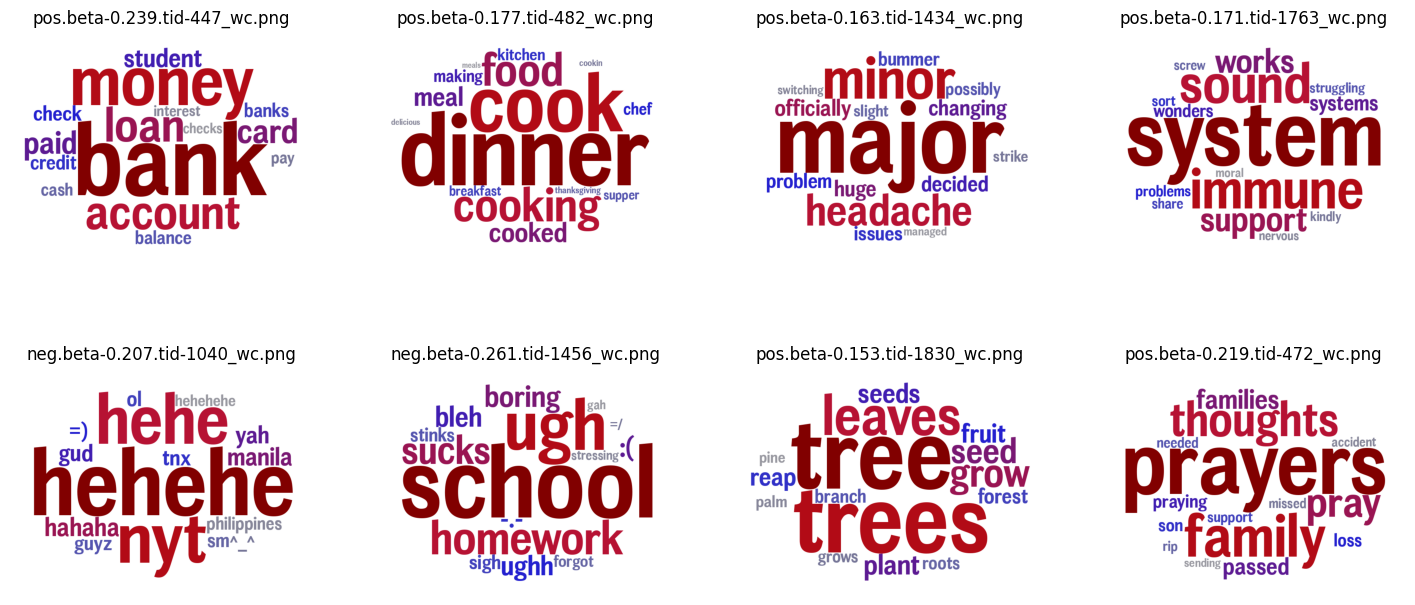

In [20]:
from IPython.utils import io
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv
import re
from google.colab import files
import os
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setup DLATK
def setup_dlatk():
    subprocess.run("pip install dlatk[wordcloud,langid]", shell=True)
    result = subprocess.run("dlatkInterface.py --colabify", shell=True, capture_output=True, text=True)
    try:
        from dlatk.tools.colab_methods import colab_shorten_and_bg
        colab_shorten_and_bg()
    except ImportError as e:
        print("Some optional setup steps failed:", e)
    return result.stdout + '\n' + result.stderr

# Suppressing output
with io.capture_output() as captured:
    setup_output = setup_dlatk()

if 'DLATK exits with success! A good day indeed' in setup_output:
    print("DLATK setup completed successfully. Enjoy your analysis!")
else:
    print("DLATK setup may have encountered issues. Please check the logs for more details.")

# Define global variables
database_name = "colab_csv"
generated_feature_table_name = ""
text_column_name = ""
id_column_name = ""
file_name_without_extension = ""
outcome_table_name = "users404.csv"
outcomes = ""
controls = ""
file_name = ""
current_feature_option = ""  # Global variable to hold the feature option value

# Upload and configure text data
def upload_text_data():
    global text_column_name, id_column_name, file_name_without_extension, generated_feature_table_name, file_name, current_feature_option

    text_filename = widgets.Dropdown(options=["Upload from desktop", "msgs404u.csv"], description='Select File:')
    file_select_button = widgets.Button(description="Load File")
    text_column_dropdown = widgets.Dropdown(description='Text Column:')
    id_column_dropdown = widgets.Dropdown(description='ID Column:')
    feature_options = widgets.Dropdown(options=['Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'topics'], description='Features:')
    confirm_button = widgets.Button(description="Process Data")

    display(text_filename, file_select_button)
    display(text_column_dropdown, id_column_dropdown, feature_options, confirm_button)
    feature_options.observe(lambda change: globals().update(current_feature_option=change.new), names='value')

    def update_dropdowns(file_path):
        if os.path.exists(file_path):
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                headers = next(reader, None)
            text_column_dropdown.options = [col for col in headers if not col.endswith("_id")]
            id_column_dropdown.options = [col for col in headers if col.endswith("_id")]
            print(f'File ready for use: {file_path}')
        else:
            print("File not found. Please ensure the file exists and try again.")

    def on_file_select(b):
        print("File select button clicked")
        global file_name_without_extension, file_name
        if text_filename.value == "Upload from desktop":
            try:
                print("Attempting to upload file")
                uploaded_files = files.upload()
                if uploaded_files:
                    file_name = next(iter(uploaded_files))
                    file_name = re.sub(r" \(\d+\)", "", file_name)
                    if not file_name.endswith('.csv'):
                        file_name += '.csv'
                    file_path = os.path.join("/content", file_name)
                    update_dropdowns(file_path)
                    file_name_without_extension = os.path.splitext(file_name)[0]
                    print("File upload successful")
            except Exception as e:
                print(f"Failed to upload file: {str(e)}")
        else:
            file_name = re.sub(r" \(\d+\)", "", text_filename.value)
            if not file_name.endswith('.csv'):
                file_name += '.csv'
            file_path = os.path.join("/content", file_name)
            update_dropdowns(file_path)
            file_name_without_extension = os.path.splitext(file_name)[0]

    def on_confirm(b):
        global text_column_name, id_column_name, generated_feature_table_name, current_feature_option
        text_column_name = text_column_dropdown.value
        id_column_name = id_column_dropdown.value
        if current_feature_option == '1to2grams-unfiltered':
            generate_unfiltered_feature_table()
        elif current_feature_option == '1to2grams-filtered':
            combined_feature_table_name = "1to2gram"
            command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                      f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                      f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name} " \
                      f"--feat_occ_filter --set_p_occ 0.10 --feat_colloc_filter"
            print(f"Executing: {command}")
            process = subprocess.Popen(command, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
            while True:
                output = process.stdout.readline()
                if output == '' and process.poll() is not None:
                    break
                if output:
                    print(output.strip())
            if process.returncode == 0:
                generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}$0_1$pmi3_0"
                print(f"Generated feature table: {generated_feature_table_name}")
                upload_correlate_data()

        elif feature_options.value == 'topics':
            # First command generation
            ngram_command = f"dlatkInterface.py -d {database_name} -t {file_name_without_extension}.csv -g {id_column_name} " \
                            f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                            f"--group_freq_thresh 100 --add_ngrams -n 1 --feat_occ_filter --set_p_occ 3"
            print(f"Executing: {ngram_command}")
            ngram_process = subprocess.Popen(ngram_command, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
            while True:
                output = ngram_process.stdout.readline()
                if output == '' and ngram_process.poll() is not None:
                    break
                if output:
                    print(output.strip())
            if ngram_process.returncode != 0:
                print("Failed to generate ngrams feature table.")
                return

            # Second command generation
            lexicon_command = f"dlatkInterface.py -d {database_name} -t {file_name_without_extension}.csv -g {id_column_name} " \
                              f"--group_freq_thresh 100 -f 'feat$1gram${file_name_without_extension}${id_column_name}$3_0' " \
                              f"--add_lex -l fb2000_cp --weighted_lex"
            print(f"Executing: {lexicon_command}")
            lexicon_process = subprocess.Popen(lexicon_command, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
            while True:
                output = lexicon_process.stdout.readline()
                if output == '' and lexicon_process.poll() is not None:
                    break
                if output:
                    print(output.strip())
            if lexicon_process.returncode == 0:
                generated_feature_table_name = f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"
                print(f"Generated feature table: {generated_feature_table_name}")
                upload_correlate_data()
            else:
                print("Failed to apply lexicon features.")


    def generate_unfiltered_feature_table():
        global generated_feature_table_name

        combined_feature_table_name = "1to2gram"
        command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                  f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                  f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name}"
        print(f"Generating unfiltered 1to2grams feature table: {command}")
        print(f"Executing: {command}")
        process = subprocess.Popen(command, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        while True:
            output = process.stdout.readline()
            if output == '' and process.poll() is not None:
                break
            if output:
                print(output.strip())
        if process.returncode == 0:
            generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}$0_1$pmi3_0"
            print(f"Generated feature table: {generated_feature_table_name}")
            upload_correlate_data()

    file_select_button.on_click(on_file_select)
    confirm_button.on_click(on_confirm)

upload_text_data()


# Upload correlate data (Code B)
def upload_correlate_data():
    global outcome_table_name, generated_feature_table_name

    dataset_dropdown = widgets.Dropdown(options=["Upload from desktop", "users404.csv"], description='Select Dataset:')
    confirm_button = widgets.Button(description="Confirm Dataset")

    def dataset_selected(b):
        chosen_dataset = dataset_dropdown.value
        if chosen_dataset == "Upload from desktop":
            upload = widgets.FileUpload(accept='.csv', multiple=False)
            display(upload)

            def file_uploaded(change):
                for filename, file in upload.value.items():
                    with open(filename, 'wb') as f:
                        f.write(file['content'])
                    outcome_table_name = filename
                if outcome_table_name:
                    print(f"File {outcome_table_name} uploaded and set.")
                    configure_parameters()  # Call configure once the file is set

            upload.observe(file_uploaded, names='value')

        else:
            outcome_table_name = chosen_dataset
            if os.path.exists(outcome_table_name):
                print(f"Dataset {outcome_table_name} selected.")
                configure_parameters()  # Call configure once the file is selected

    confirm_button.on_click(dataset_selected)
    display(dataset_dropdown, confirm_button)

# Configure parameters (Code C)
# Configure parameters (Code C)
def configure_parameters():
    global generated_feature_table_name, outcomes, controls, outcome_table_name, current_feature_option

    print(f"Generated feature table2: {generated_feature_table_name}")

    if os.path.exists(outcome_table_name):
        with open(outcome_table_name, newline='') as csvfile:
            reader = csv.reader(csvfile)
            column_headers = next(reader, None)

        if column_headers:
            outcomes_title = widgets.Label('Outcomes:')
            controls_title = widgets.Label('Controls:')
            outcomes_widgets = {}
            controls_widgets = {}
            outcomes_cat_widgets = {}
            controls_cat_widgets = {}

            # Create checkboxes for each column header
            for option in column_headers:
                if "_id" not in option:
                    outcomes_widgets[option] = widgets.Checkbox(description=option, value=False)
                    controls_widgets[option] = widgets.Checkbox(description=option, value=False)
                    outcomes_cat_widgets[option] = widgets.Checkbox(
                        description='Is this variable Categorical?',
                        value=False,
                        layout=widgets.Layout(display='none')
                    )
                    controls_cat_widgets[option] = widgets.Checkbox(
                        description='Is this variable Categorical?',
                        value=False,
                        layout=widgets.Layout(display='none')
                    )

            def handle_checkbox_change(change):
                global outcomes, controls
                option = change.owner.description
                if change.owner in outcomes_widgets.values():
                    controls_widgets[option].disabled = change.new
                    outcomes_cat_widgets[option].layout.display = 'flex' if change.new else 'none'
                elif change.owner in controls_widgets.values():
                    outcomes_widgets[option].disabled = change.new
                    controls_cat_widgets[option].layout.display = 'flex' if change.new else 'none'

            for checkbox in outcomes_widgets.values():
                checkbox.observe(handle_checkbox_change, names='value')
            for checkbox in controls_widgets.values():
                checkbox.observe(handle_checkbox_change, names='value')

            submit_button = widgets.Button(description="Submit")
            make_wordclouds_checkbox = widgets.Checkbox(value=False, description='Enable Wordclouds')
            make_wordclouds_title = widgets.Label('Make Wordclouds:')

            def on_submit(b):
                global outcomes, controls
                outcomes = [k for k, v in outcomes_widgets.items() if v.value]
                controls = [k for k, v in controls_widgets.items() if v.value]
                cat_to_bin_outcomes = [k for k, v in outcomes_cat_widgets.items() if v.value]
                cat_to_bin_controls = [k for k, v in controls_cat_widgets.items() if v.value]
                cat_to_bin_parts = [','.join(cat_to_bin_outcomes), ','.join(cat_to_bin_controls)]
                cat_to_bin_parts = [part for part in cat_to_bin_parts if part]
                cat_to_bin_cmd = f"--cat_to_bin {' '.join(cat_to_bin_parts)}" if cat_to_bin_parts else ""

                if current_feature_option == "topics":
                    command = f"dlatkInterface.py -d {database_name} -t {file_name} -g user_id --group_freq_thresh 100 " \
                              f"-f 'feat$cat_fb2000_cp_w${file_name_without_extension}$user_id$1gra' --outcome_table users404.csv " \
                              f"--outcomes {','.join(outcomes)} --controls {','.join(controls)} {cat_to_bin_cmd} --topic_lexicon fb2000_freq_t50ll"
                    if make_wordclouds_checkbox.value:
                        command += " --make_topic_wordclouds"
                else:
                    command = (
                        f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                        f"--group_freq_thresh 100 --feat_table '{generated_feature_table_name}' "
                        f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                        f"--controls {','.join(controls)} {cat_to_bin_cmd} --rmatrix"
                    )
                    if make_wordclouds_checkbox.value:
                        command += " --make_wordclouds"

                print("Command to execute:", command)
                process = subprocess.Popen(command, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                while True:
                    output = process.stdout.readline()
                    if output == '' and process.poll() is not None:
                        break
                    if output:
                        print(output.strip())
                if process.returncode == 0:
                    display_wordclouds()

            submit_button.on_click(on_submit)

            # Display the widgets
            display(outcomes_title)
            for option, checkbox in outcomes_widgets.items():
                display(widgets.HBox([checkbox, outcomes_cat_widgets[option]]))
            display(controls_title)
            for option, checkbox in controls_widgets.items():
                display(widgets.HBox([checkbox, controls_cat_widgets[option]]))
            display(make_wordclouds_title, make_wordclouds_checkbox, submit_button)

        else:
            print("Failed to read column names from the outcome table.")
    else:
        print("Outcome table name not set or file does not exist. Please ensure a file is uploaded in Part 1.")


def display_wordclouds():
    global outcomes, controls, generated_feature_table_name
    if current_feature_option == "topics":
        feature_table_name = generated_feature_table_name.replace('$', '.')
        wordcloud_file_name = f"{feature_table_name}.{','.join(outcomes)}.{','.join(controls)}__0.freq100._topic_tagcloud_wordclouds"
        print("Wordcloud File Name:", wordcloud_file_name)
        print_topic_wordclouds(f"./{wordcloud_file_name}/{','.join(outcomes)}", 8)
    else:
        from dlatk.tools.colab_methods import print_wordclouds
        feature_table_name = generated_feature_table_name.replace('$', '.')
        wordcloud_file_name = f"{feature_table_name}.{','.join(outcomes)}.{','.join(controls)}__0.freq100._tagcloud_wordclouds"
        print("Wordcloud File Name:", wordcloud_file_name)
        print_wordclouds(wordcloud_file_name)

def print_topic_wordclouds(wordcloud_folder, num_topics=8, images_per_row=4):
    images = glob.glob(os.path.join(wordcloud_folder, '*.png'))
    to_display = images[:min(num_topics, len(images))]

    fig, axes = plt.subplots(math.ceil(num_topics/images_per_row), images_per_row, figsize=(18, 8))
    for index, image in enumerate(to_display):
        axes[int(index/images_per_row), index%images_per_row].set_axis_off()
        axes[int(index/images_per_row), index%images_per_row].set_title(image.split('/')[-1])
        axes[int(index/images_per_row), index%images_per_row].imshow(mpimg.imread(image))



In [ ]:
                if current_feature_option == "topics":
                    command = f"dlatkInterface.py -d {database_name} -t {file_name} -g user_id --group_freq_thresh 50 " \
                              f"-f 'feat$cat_fb2000_cp_w${file_name_without_extension}$user_id$1gra' --outcome_table users404.csv " \
                              f"--outcomes age --controls gender --cat_to_bin gender --topic_lexicon fb2000_freq_t50ll"
                    if make_wordclouds_checkbox.value:
                        command += " --make_topic_wordclouds"
                else:
                    command = (
                        f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                        f"--group_freq_thresh 100 --feat_table '{generated_feature_table_name}' "
                        f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                        f"--controls {','.join(controls)} {cat_to_bin_cmd} --rmatrix"
                    )
                    if make_wordclouds_checkbox.value:

In [ ]:
#@markdown Test code: Check which tables are formed so far

!dlatkInterface.py \
  -d colab_csv -t msgs404u.csv -g user_id \
  --show_feat_tables

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-05-08 07:31:35
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db

Found 5 available tables
----
feat$1gram$msgs404u$user_id
feat$meta_1gram$msgs404u$user_id
feat$2gram$msgs404u$user_id
feat$meta_2gram$msgs404u$user_id
feat$1to2gram$msgs404u$user_id
-------
Settings:

Database - colab_csv
Corpus - msgs404u.csv
Group ID - user_id
-------
Interface Runtime: 0.01 seconds
DLATK exits with success! A good day indeed  ¯\_(ツ)_/¯.


In [ ]:
from IPython.utils import io
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv
import re
from google.colab import files
import os
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setup DLATK
def setup_dlatk():
    subprocess.run("pip install dlatk[wordcloud,langid]", shell=True)
    result = subprocess.run("dlatkInterface.py --colabify", shell=True, capture_output=True, text=True)
    try:
        from dlatk.tools.colab_methods import colab_shorten_and_bg
        colab_shorten_and_bg()
    except ImportError as e:
        print("Some optional setup steps failed:", e)
    return result.stdout + '\n' + result.stderr

# Suppressing output
with io.capture_output() as captured:
    setup_output = setup_dlatk()

if 'DLATK exits with success! A good day indeed' in setup_output:
    print("DLATK setup completed successfully. Enjoy your analysis!")
else:
    print("DLATK setup may have encountered issues. Please check the logs for more details.")

# Define global variables
database_name = "colab_csv"
generated_feature_table_name = ""
text_column_name = ""
id_column_name = ""
file_name_without_extension = ""
outcome_table_name = ""

# Upload and configure text data (Code A)
def upload_text_data():
    global text_column_name, id_column_name, file_name_without_extension, generated_feature_table_name

    text_filename = widgets.Dropdown(options=["Upload from desktop", "msgs404u.csv"], description='Select File:')
    display(text_filename)

    def process_file(change):
        clear_output(wait=True)
        file_path = None
        if change['new'] == "Upload from desktop":
            print("Please upload a file from the desktop.")
            uploaded_files = files.upload()
            if uploaded_files:
                file_name = next(iter(uploaded_files))
                file_name = re.sub(r" \(\d+\)", "", file_name)
                if not file_name.endswith('.csv'):
                    file_name += '.csv'
                file_path = os.path.join("/content", file_name)
                print(f'Uploaded file name: {file_name}')
            else:
                print("No file uploaded. Please upload a file to proceed.")
        else:
            file_name = re.sub(r" \(\d+\)", "", change['new'])
            if not file_name.endswith('.csv'):
                file_name += '.csv'
            file_path = os.path.join("/content", file_name)
            print(f'Text file selected: {file_name}')

        if file_path and os.path.exists(file_path):
            print(f'File ready for use: {file_path}')
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                available_columns = next(reader, None)

            text_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if not col.endswith("_id")], description='Text Column:')
            id_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if col.endswith("_id")], description='ID Column:')
            feature_options = widgets.Dropdown(options=['Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'topics'], description='Features:')

            def confirm_columns(b):
                global text_column_name, id_column_name
                text_column_name = text_column_dropdown.value
                id_column_name = id_column_dropdown.value
                print(f"Text column set to: {text_column_name}, ID column set to: {id_column_name}")
                display(feature_options)

            confirm_button = widgets.Button(description="Confirm Columns")
            confirm_button.on_click(confirm_columns)
            display(text_column_dropdown, id_column_dropdown, confirm_button)

            # Feature extraction functions
            def generate_unfiltered_feature_table():
                combined_feature_table_name = "1to2gram"
                command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                          f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                          f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name}"
                print(f"Generating unfiltered 1to2grams feature table: {command}")
                subprocess.run(command, shell=True)
                generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}"
                print(f"Generated feature table: {generated_feature_table_name}")

            def extract_features(b):
                if feature_options.value == '1to2grams-unfiltered':
                    generate_unfiltered_feature_table()
                elif feature_options.value == '1to2grams-filtered':
                    combined_feature_table_name = "1to2gram"
                    command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                              f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                              f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name} " \
                              f"--feat_occ_filter --set_p_occ 0.10 --feat_colloc_filter"
                    print(f"Executing: {command}")
                    subprocess.run(command, shell=True)
                    generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}$0_1$pmi3_0"
                    print(f"Generated feature table: {generated_feature_table_name}")

                elif feature_options.value == 'topics':
                    lex_table_name = f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"
                    command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                              f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                              f"--group_freq_thresh 100 --add_lex_table -l fb2000_cp --weighted_lexicon"
                    print(f"Executing: {command}")
                    subprocess.run(command, shell=True)
                    print(f"Generated LDA feature table: {lex_table_name}")

            feature_options.observe(extract_features, names='value')
        else:
            print("File not found. Please ensure the file exists and try again.")

    text_filename.observe(process_file, names='value')

upload_text_data()

# Upload correlate data (Code B)
def upload_correlate_data():
    global outcome_table_name

    default_dataset = "users404.csv"
    file_path = os.path.join("/content", default_dataset)
    print(f'Default dataset selected: {default_dataset}')

    if os.path.exists(file_path):
        print(f'Dataset ready for use: {file_path}')
        outcome_table_name = default_dataset
    else:
        print("Dataset not found. Please ensure the dataset exists and try again.")

upload_correlate_data()

# Configure parameters (Code C)
def configure_parameters():
    # Assuming Code C content here
    print(f"Configuring with outcome table: {outcome_table_name}")

configure_parameters()

# Generate and display word clouds (Code D)
def display_wordclouds():
    # Assuming Code D content here
    print("Displaying word clouds...")

display_wordclouds()


Text file selected: msgs404u.csv
File ready for use: /content/msgs404u.csv


Dropdown(description='Text Column:', options=('created_date', 'message'), value='created_date')

Dropdown(description='ID Column:', options=('message_id', 'user_id'), value='message_id')

Button(description='Confirm Columns', style=ButtonStyle())

Text column set to: message, ID column set to: user_id


Dropdown(description='Features:', options=('Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'top…

In [ ]:
from IPython.utils import io
import subprocess
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv
import re
from google.colab import files
import os
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setup DLATK
def setup_dlatk():
    subprocess.run("pip install dlatk[wordcloud,langid]", shell=True)
    result = subprocess.run("dlatkInterface.py --colabify", shell=True, capture_output=True, text=True)
    try:
        from dlatk.tools.colab_methods import colab_shorten_and_bg
        colab_shorten_and_bg()
    except ImportError as e:
        print("Some optional setup steps failed:", e)
    return result.stdout + '\n' + result.stderr

# Suppressing output
with io.capture_output() as captured:
    setup_output = setup_dlatk()

if 'DLATK exits with success! A good day indeed' in setup_output:
    print("DLATK setup completed successfully. Enjoy your analysis!")
else:
    print("DLATK setup may have encountered issues. Please check the logs for more details.")

# Define global variables
database_name = "colab_csv"
generated_feature_table_name = ""
text_column_name = ""
id_column_name = ""
file_name_without_extension = ""
outcome_table_name = ""

# Upload and configure text data (Code A)
def upload_text_data():
    global text_column_name, id_column_name, file_name_without_extension, generated_feature_table_name

    #@markdown ### Select text Dataset or Upload from Desktop
    #@markdown Choose a text dataset from the dropdown, or select "Upload from desktop" to upload your own file.
    #@markdown After making your selection, click the __play button__ at the top left to proceed.

    text_filename = widgets.Dropdown(options=["Upload from desktop", "msgs404u.csv"], description='Select File:')
    display(text_filename)

    def process_file(change):
        clear_output(wait=True)
        file_path = None
        if change['new'] == "Upload from desktop":
            print("Please upload a file from the desktop.")
            uploaded_files = files.upload()
            if uploaded_files:
                file_name = next(iter(uploaded_files))
                file_name = re.sub(r" \(\d+\)", "", file_name)
                if not file_name.endswith('.csv'):
                    file_name += '.csv'
                file_path = os.path.join("/content", file_name)
                print(f'Uploaded file name: {file_name}')
            else:
                print("No file uploaded. Please upload a file to proceed.")
        else:
            file_name = re.sub(r" \(\d+\)", "", change['new'])
            if not file_name.endswith('.csv'):
                file_name += '.csv'
            file_path = os.path.join("/content", file_name)
            print(f'Text file selected: {file_name}')

        if file_path and os.path.exists(file_path):
            print(f'File ready for use: {file_path}')
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                available_columns = next(reader, None)

            text_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if not col.endswith("_id")], description='Text Column:')
            id_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if col.endswith("_id")], description='ID Column:')

            def confirm_columns(b):
                global text_column_name, id_column_name
                text_column_name = text_column_dropdown.value
                id_column_name = id_column_dropdown.value
                print(f"Text column set to: {text_column_name}, ID column set to: {id_column_name}")

            confirm_button = widgets.Button(description="Confirm Columns")
            confirm_button.on_click(confirm_columns)
            display(text_column_dropdown, id_column_dropdown, confirm_button)
        else:
            print("File not found. Please ensure the file exists and try again.")

    text_filename.observe(process_file, names='value')

upload_text_data()

# Upload correlate data (Code B)
def upload_correlate_data():
    global outcome_table_name

    default_dataset = "users404.csv"
    file_path = os.path.join("/content", default_dataset)
    print(f'Default dataset selected: {default_dataset}')

    if os.path.exists(file_path):
        print(f'Dataset ready for use: {file_path}')
        outcome_table_name = default_dataset
    else:
        print("Dataset not found. Please ensure the dataset exists and try again.")

upload_correlate_data()

# Configure parameters (Code C)
def configure_parameters():
    # Assuming Code C content here
    print(f"Configuring with outcome table: {outcome_table_name}")

configure_parameters()

# Generate and display word clouds (Code D)
def display_wordclouds():
    # Assuming Code D content here
    print("Displaying word clouds...")

display_wordclouds()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DLATK setup completed successfully. Enjoy your analysis!


Dropdown(description='Select File:', options=('Upload from desktop', 'msgs404u.csv'), value='Upload from deskt…

Default dataset selected: users404.csv
Dataset ready for use: /content/users404.csv
Configuring with outcome table: users404.csv
Displaying word clouds...


In [ ]:
from IPython.utils import io
import subprocess

global text_column_name, id_column_name
global file_name_without_extension
global generated_feature_table_name
global feature_table_mapping
global outcomes, controls

#@markdown Click the __Play button__ to the left to start the setup. Proceed to the next stage once you see:
#@markdown "DLATK setup completed successfully. Enjoy your analysis!"

def setup_dlatk():
    # Install DLATK with additional features
    subprocess.run("pip install dlatk[wordcloud,langid]", shell=True)

    # Initialize DLATK for Colab environment
    result = subprocess.run("dlatkInterface.py --colabify", shell=True, capture_output=True, text=True)

    # Optional: Adjust Colab output for a better experience
    try:
        from dlatk.tools.colab_methods import colab_shorten_and_bg
        colab_shorten_and_bg()  # This shortens output blocks and changes the output background color.
    except ImportError as e:
        print("Some optional setup steps failed:", e)

    return result.stdout + '\n' + result.stderr

# Suppressing the output of the main installation and setup commands
with io.capture_output() as captured:
    setup_output = setup_dlatk()

# Check the captured output for a specific success message
if 'DLATK exits with success! A good day indeed' in setup_output:
    print("DLATK setup completed successfully. Enjoy your analysis!")
    # If DLATK setup is successful, proceed to run codeB
    def run_codeB():
        import subprocess
        import ipywidgets as widgets
        from IPython.display import display, clear_output
        import csv
        import re
        from google.colab import files
        import os

        #@title Upload text data
        #@markdown ### Select text Dataset or Upload from Desktop
        #@markdown Choose a text dataset from the dropdown, or select "Upload from desktop" to upload your own file.
        #@markdown After making your selection, click the __play button__ at the top left to proceed.

        text_filename = "msgs404u.csv" #@param ["Upload from desktop", "msgs404u.csv"]
        file_path = None

        def sanitize_file_name(file_name):
            base_file_name = re.sub(r" \(\d+\)", "", file_name)
            if not base_file_name.endswith('.csv'):
                base_file_name += '.csv'
            return base_file_name

        def add_message_id_if_missing(file_path):
            headers_changed = False
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                headers = next(reader, None)

                if headers and 'message_id' not in headers:
                    headers_changed = True
                    new_rows = [['message_id'] + headers]
                    new_rows += [[str(i+1)] + row for i, row in enumerate(reader)]

            if headers_changed:
                with open(file_path, mode='w', encoding='utf-8', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerows(new_rows)
                print("Added 'message_id' column and saved changes.")
            else:
                print("'message_id' column already exists.")

        if text_filename != "Upload from desktop":
            file_name = sanitize_file_name(text_filename)
            file_path = os.path.join("/content", file_name)
            print(f'Text file selected: {file_name}')
        else:
            print("Please upload a file from the desktop.")
            uploaded_files = files.upload()
            if uploaded_files:
                file_name = next(iter(uploaded_files))
                file_name = sanitize_file_name(file_name)
                file_path = os.path.join("/content", file_name)
                add_message_id_if_missing(file_path)
                print(f'Uploaded file name: {file_name}')
            else:
                print("No file uploaded. Please upload a file to proceed.")

        if os.path.exists(file_path):
            print(f'File ready for use: {file_path}')
        else:
            print("File not found. Please ensure the file exists and try again.")

        #@title Select Text and ID Columns
        #@markdown Select the text and ID columns for analysis:
        def get_available_columns(file_path):
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                return next(reader, None)

        available_columns = get_available_columns(file_path) if file_path else []
        text_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if not col.endswith("_id")], description='Text Column:')
        id_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if col.endswith("_id")], description='ID Column:')
        confirm_button = widgets.Button(description="Confirm Columns")

        def confirm_columns(b):
            text_column_name = text_column_dropdown.value
            id_column_name = id_column_dropdown.value
            print(f"Text column set to: {text_column_name}, ID column set to: {id_column_name}")

        confirm_button.on_click(confirm_columns)
        display(text_column_dropdown, id_column_dropdown, confirm_button)

        #@title Feature Extraction Setup
        #@markdown Setup feature extraction parameters and execute:

        database_name = "colab_csv"
        file_name_without_extension = file_name.rsplit('.', 1)[0] if file_name else "default_filename"
        feature_options = widgets.Dropdown(options=['Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'topics'], description='Features:')
        run_feature_button = widgets.Button(description="Extract Features")

        def generate_unfiltered_feature_table():
            combined_feature_table_name = "1to2gram"
            command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                      f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                      f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name}"
            print(f"Generating unfiltered 1to2grams feature table: {command}")
            subprocess.run(command, shell=True)
            generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}"
            print(f"Generated feature table: {generated_feature_table_name}")

        def extract_features(b):
            group_freq_thresh = 100  # Default value, used if not topic modeling

            if feature_options.value == '1to2grams-unfiltered':
                generate_unfiltered_feature_table()

            elif feature_options.value == '1to2grams-filtered':
                combined_feature_table_name = "1to2gram"
                command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                          f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                          f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name} " \
                          f"--feat_occ_filter --set_p_occ 0.10 --feat_colloc_filter"
                print(f"Executing: {command}")
                subprocess.run(command, shell=True)
                generated_feature_table_name = f"feat${combined_feature_table_name}${file_naup_freq_thresh {group_freq_thresh} --add_lex_table -l fb2000_cp --weighted_lexicon"
                print(f"Executing: {command}")
                subprocess.run(command, shell=True)
                print(f"Generated LDA feature table: {lex_table_name}")

        run_feature_button.on_click(extract_features)
        display(feature_options, run_feature_button)

    run_codeB()  # Execute codeB only after DLATK is successfully set up.
else:
    print("DLATK setup may have encountered issues. Please check the logs for more details.")

import re
from google.colab import files
import os

# codeB
def upload_dataset():

  #@title Upload correlate data

  #@markdown Select a predefined dataset from the dropdown menu, or choose "Upload from desktop" to upload your own dataset.

  # This is a dropdown for choosing between default datasets or uploading your own
  default_dataset = "users404.csv" #@param ["Upload from desktop", "users404.csv"]

  #@markdown If you opt for desktop upload, click the "Choose Files" button that appears upon executing this cell.

  # Function to check if the file exists (for local files)
  def file_exists(file_path):
      return os.path.exists(file_path)

  # Sanitizes file names to ensure they end with '.csv'
  def sanitize_file_name(file_name):
      base_file_name = re.sub(r" \(\d+\)", "", file_name)
      if not base_file_name.endswith('.csv'):
          base_file_name += '.csv'
      return base_file_name

  file_path = None  # Initialize file_path variable

  if default_dataset != "Upload from desktop":
      # If a default dataset is selected, set the file_path accordingly
      outcome_table_name = sanitize_file_name(default_dataset)
      file_path = os.path.join("/content", outcome_table_name)
      print(f'Default dataset selected: {outcome_table_name}')
  else:
      print("Please upload a dataset from the desktop.")
      uploaded_files = files.upload()
      if uploaded_files:
          # Assuming only one file is uploaded, use its name
          filename = next(iter(uploaded_files))
          outcome_table_name = sanitize_file_name(filename)  # Sanitize the uploaded file's name
          file_path = os.path.join("/content", outcome_table_name)
          print(f'Uploaded dataset name: {outcome_table_name}')
      else:
          print("No dataset uploaded. Please upload a dataset to proceed.")

  # Verify the file's existence and readiness for use
  if file_path and file_exists(file_path):
      print(f'Dataset ready for use: {file_path}')
  else:
      print("Dataset not found. Please ensure the dataset exists and try again.")

upload_dataset()

# codeC
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv

# Code for configuring parameters and executing a command based on user selections
def configure_and_execute():

  #@title Configure Parameters

  #@markdown Before executing the command, please adjust the parameters below according to your dataset and analysis needs.
  feature_table_mapping = {
      "1to2grams-filtered-table": f"feat$1to2gram${file_name_without_extension}${id_column_name}$0_1$pmi3_0",
      "1to2grams-unfiltered-table": f"feat$1to2gram${file_name_without_extension}${id_column_name}",
      "topics-table": f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"  # Adding topics-related feature table option
  }

  if 'outcome_table_name' in globals():
      # Open and read the CSV file to extract column names
      with open(outcome_table_name, newline='') as csvfile:
          reader = csv.reader(csvfile)
          column_headers = next(reader, None)

      if column_headers:
          # Exclude columns containing '_id' from being displayed as checkboxes
          filtered_column_headers = [option for option in column_headers if "_id" not in option]

          feature_table_dropdown = widgets.Dropdown(options=feature_table_mapping, description='Feature Table:')

          outcomes_title = widgets.Label('Outcomes:')
          controls_title = widgets.Label('Controls:')
          outcomes_widgets = {}
          controls_widgets = {}
          outcomes_cat_widgets = {}
          controls_cat_widgets = {}

          # Create checkboxes for each column header
          for option in filtered_column_headers:
              outcomes_widgets[option] = widgets.Checkbox(description=option, value=False)
              controls_widgets[option] = widgets.Checkbox(description=option, value=False)
              # Replace RadioButtons with a single Checkbox for categorical selection
              outcomes_cat_widgets[option] = widgets.Checkbox(
                  description='Is this variable Categorical?',
                  value=False,
                  layout={'width': 'max-content'},
                  style={'description_width': 'initial'}
              )
              controls_cat_widgets[option] = widgets.Checkbox(
                  description='Is this variable Categorical?',
                  value=False,
                  layout={'width': 'max-content'},
                  style={'description_width': 'initial'}
              )
              outcomes_cat_widgets[option].layout.display = 'none'
              controls_cat_widgets[option].layout.display = 'none'

          def handle_checkbox_change(change):
              option = change.owner.description
              if change.owner in outcomes_widgets.values():
                  controls_widgets[option].disabled = change.new
                  outcomes_cat_widgets[option].layout.display = 'flex' if change.new else 'none'
              elif change.owner in controls_widgets.values():
                  outcomes_widgets[option].disabled = change.new
                  controls_cat_widgets[option].layout.display = 'flex' if change.new else 'none'

          for checkbox in outcomes_widgets.values():
              checkbox.observe(handle_checkbox_change, names='value')
          for checkbox in controls_widgets.values():
              checkbox.observe(handle_checkbox_change, names='value')

          def on_submit(change):
              clear_output(wait=True)
              outcomes = [k for k, v in outcomes_widgets.items() if v.value]
              controls = [k for k, v in controls_widgets.items() if v.value]
              cat_to_bin_outcomes = [k for k, v in outcomes_cat_widgets.items() if v.value]
              cat_to_bin_controls = [k for k, v in controls_cat_widgets.items() if v.value]

              feature_table_name = feature_table_dropdown.value
              make_wordclouds = make_wordclouds_checkbox.value

              # Construct the command dynamically based on selections
              cat_to_bin_parts = [','.join(cat_to_bin_outcomes), ','.join(cat_to_bin_controls)]
              cat_to_bin_parts = [part for part in cat_to_bin_parts if part]  # Remove empty strings
              cat_to_bin_cmd = f"--cat_to_bin {' '.join(cat_to_bin_parts)}" if cat_to_bin_parts else ""

              command = (
                  f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} "
                  f"--group_freq_thresh 100 --feat_table '{feature_table_name}' "
                  f"--outcome_table {outcome_table_name} --outcomes {','.join(outcomes)} "
                  f"--controls {','.join(controls)} {cat_to_bin_cmd} --rmatrix"
              )
              if make_wordclouds:
                  if feature_table_name == feature_table_mapping['topics-table']:
                      command += " --make_topic_wordclouds"
                  else:
                      command += " --make_wordclouds"
              print("Command to execute:", command)
              process = subprocess.run(command, shell=True, text=True, capture_output=True)
              print(process.stdout)
              if process.stderr:
                  print("Error:", process.stderr)

          submit_button = widgets.Button(description="Submit")
          submit_button.on_click(on_submit)

          make_wordclouds_title = widgets.Label('Make Wordclouds:')
          make_wordclouds_checkbox = widgets.Checkbox(value=False, description='Enable Wordclouds')

          # Display the widgets
          display(feature_table_dropdown)
          display(outcomes_title)
          for option, checkbox in outcomes_widgets.items():
              display(widgets.HBox([checkbox, outcomes_cat_widgets[option]]))
          display(controls_title)
          for option, checkbox in controls_widgets.items():
              display(widgets.HBox([checkbox, controls_cat_widgets[option]]))
          display(make_wordclouds_title, make_wordclouds_checkbox, submit_button)

      else:
          print("Failed to read column names from the outcome table.")
  else:
      print("Outcome table name not set. Please ensure a file is uploaded in Part 1.")

  pass

configure_and_execute()

# Import statements for codeD
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dlatk.tools.colab_methods import print_wordclouds

# Code to display word clouds
def display_wordclouds():
  # Remaining code for displaying word clouds goes here...

  feature_table_name = feature_table_dropdown.value.replace('$', '.')

  def display_wordclouds(feature_table_name, outcomes, controls):
      # This function decides which type of word clouds to display based on the feature table selected.
      if feature_table_name == feature_table_mapping['topics-table']:
          print_topic_wordclouds("/content/_alltopics/", 8)
      else:
          wordcloud_file_name = f"{feature_table_name.replace('$', '.')}.{','.join(outcomes)}.{','.join(controls)}__0.freq100._tagcloud_wordclouds"
          print("Wordcloud File Name:", wordcloud_file_name)
          print_wordclouds(wordcloud_file_name)

  def print_topic_wordclouds(wordcloud_folder, num_topics=8, images_per_row=4):
      # This function handles the displaying of topic word clouds specifically.
      images = glob.glob(os.path.join(wordcloud_folder, '*.png'))
      to_display = images[:min(num_topics, len(images))]

      if len(to_display) == 0:
          print("No topic wordcloud images found in the specified folder.")
          return

      fig, axes = plt.subplots(math.ceil(num_topics / images_per_row), images_per_row, figsize=(18, 8))
      for index, image in enumerate(to_display):
          ax = axes[int(index / images_per_row), index % images_per_row]
          ax.set_axis_off()
          ax.set_title(image.split('/')[-1])
          ax.imshow(mpimg.imread(image))
      plt.show()

  # Example usage:
  # Assuming 'outcomes' and 'controls' are updated in the global scope by previous code execution
  display_wordclouds(feature_table_name, outcomes, controls)
  pass

display_wordclouds()





<IPython.core.display.Javascript object>

SyntaxError: f-string: expecting '}' (<ipython-input-24-2a470a657064>, line 152)

In [ ]:
from IPython.utils import io
import subprocess

#@markdown Click the __Play button__ to the left to start the setup. Proceed to the next stage once you see:
#@markdown "DLATK setup completed successfully. Enjoy your analysis!"

def setup_dlatk():
    # Install DLATK with additional features
    subprocess.run("pip install dlatk[wordcloud,langid]", shell=True)

    # Initialize DLATK for Colab environment
    result = subprocess.run("dlatkInterface.py --colabify", shell=True, capture_output=True, text=True)

    # Optional: Adjust Colab output for a better experience
    try:
        from dlatk.tools.colab_methods import colab_shorten_and_bg
        colab_shorten_and_bg()  # This shortens output blocks and changes the output background color.
    except ImportError as e:
        print("Some optional setup steps failed:", e)

    return result.stdout + '\n' + result.stderr

# Suppressing the output of the main installation and setup commands
with io.capture_output() as captured:
    setup_output = setup_dlatk()

# Check the captured output for a specific success message
if 'DLATK exits with success! A good day indeed' in setup_output:
    print("DLATK setup completed successfully. Enjoy your analysis!")
    # If DLATK setup is successful, proceed to run codeB
    def run_codeB():
        import subprocess
        import ipywidgets as widgets
        from IPython.display import display, clear_output
        import csv
        import re
        from google.colab import files
        import os

        #@title Upload text data
        #@markdown ### Select text Dataset or Upload from Desktop
        #@markdown Choose a text dataset from the dropdown, or select "Upload from desktop" to upload your own file.
        #@markdown After making your selection, click the __play button__ at the top left to proceed.

        text_filename = "msgs404u.csv" #@param ["Upload from desktop", "msgs404u.csv"]
        file_path = None

        def sanitize_file_name(file_name):
            base_file_name = re.sub(r" \(\d+\)", "", file_name)
            if not base_file_name.endswith('.csv'):
                base_file_name += '.csv'
            return base_file_name

        def add_message_id_if_missing(file_path):
            headers_changed = False
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                headers = next(reader, None)

                if headers and 'message_id' not in headers:
                    headers_changed = True
                    new_rows = [['message_id'] + headers]
                    new_rows += [[str(i+1)] + row for i, row in enumerate(reader)]

            if headers_changed:
                with open(file_path, mode='w', encoding='utf-8', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerows(new_rows)
                print("Added 'message_id' column and saved changes.")
            else:
                print("'message_id' column already exists.")

        if text_filename != "Upload from desktop":
            file_name = sanitize_file_name(text_filename)
            file_path = os.path.join("/content", file_name)
            print(f'Text file selected: {file_name}')
        else:
            print("Please upload a file from the desktop.")
            uploaded_files = files.upload()
            if uploaded_files:
                file_name = next(iter(uploaded_files))
                file_name = sanitize_file_name(file_name)
                file_path = os.path.join("/content", file_name)
                add_message_id_if_missing(file_path)
                print(f'Uploaded file name: {file_name}')
            else:
                print("No file uploaded. Please upload a file to proceed.")

        if os.path.exists(file_path):
            print(f'File ready for use: {file_path}')
        else:
            print("File not found. Please ensure the file exists and try again.")

        #@title Select Text and ID Columns
        #@markdown Select the text and ID columns for analysis:
        def get_available_columns(file_path):
            with open(file_path, mode='r', encoding='utf-8') as file:
                reader = csv.reader(file)
                return next(reader, None)

        available_columns = get_available_columns(file_path) if file_path else []
        text_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if not col.endswith("_id")], description='Text Column:')
        id_column_dropdown = widgets.Dropdown(options=[col for col in available_columns if col.endswith("_id")], description='ID Column:')
        confirm_button = widgets.Button(description="Confirm Columns")

        def confirm_columns(b):
            global text_column_name, id_column_name
            text_column_name = text_column_dropdown.value
            id_column_name = id_column_dropdown.value
            print(f"Text column set to: {text_column_name}, ID column set to: {id_column_name}")

        confirm_button.on_click(confirm_columns)
        display(text_column_dropdown, id_column_dropdown, confirm_button)

        #@title Feature Extraction Setup
        #@markdown Setup feature extraction parameters and execute:

        database_name = "colab_csv"
        global file_name_without_extension
        file_name_without_extension = file_name.rsplit('.', 1)[0] if file_name else "default_filename"
        feature_options = widgets.Dropdown(options=['Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'topics'], description='Features:')
        run_feature_button = widgets.Button(description="Extract Features")

        def generate_unfiltered_feature_table():
            global generated_feature_table_name
            combined_feature_table_name = "1to2gram"
            command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                      f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                      f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name}"
            print(f"Generating unfiltered 1to2grams feature table: {command}")
            subprocess.run(command, shell=True)
            generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}"
            print(f"Generated feature table: {generated_feature_table_name}")

        def extract_features(b):
            global generated_feature_table_name
            group_freq_thresh = 100  # Default value, used if not topic modeling

            if feature_options.value == '1to2grams-unfiltered':
                generate_unfiltered_feature_table()

            elif feature_options.value == '1to2grams-filtered':
                combined_feature_table_name = "1to2gram"
                command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                          f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                          f"--add_ngrams -n 1 2 --combine_feat_tables {combined_feature_table_name} " \
                          f"--feat_occ_filter --set_p_occ 0.10 --feat_colloc_filter"
                print(f"Executing: {command}")
                subprocess.run(command, shell=True)
                generated_feature_table_name = f"feat${combined_feature_table_name}${file_name_without_extension}${id_column_name}$0_1$pmi3_0"
                print(f"Generated feature table: {generated_feature_table_name}")

            elif feature_options.value == 'topics':
                lex_table_name = f"feat$cat_fb2000_cp_w${file_name_without_extension}${id_column_name}$1gra"
                command = f"dlatkInterface.py -d {database_name} -t {file_name} -g {id_column_name} " \
                          f"--message_field {text_column_name} --messageid_field {text_column_name}_id " \
                          f"--group_freq_thresh {group_freq_thresh} --add_lex_table -l fb2000_cp --weighted_lexicon"
                print(f"Executing: {command}")
                subprocess.run(command, shell=True)
                print(f"Generated LDA feature table: {lex_table_name}")

        run_feature_button.on_click(extract_features)
        display(feature_options, run_feature_button)

    run_codeB()  # Execute codeB only after DLATK is successfully set up.
else:
    print("DLATK setup may have encountered issues. Please check the logs for more details.")





<IPython.core.display.Javascript object>

DLATK setup completed successfully. Enjoy your analysis!
Text file selected: msgs404u.csv
File ready for use: /content/msgs404u.csv


Dropdown(description='Text Column:', options=('created_date', 'message'), value='created_date')

Dropdown(description='ID Column:', options=('message_id', 'user_id'), value='message_id')

Button(description='Confirm Columns', style=ButtonStyle())

Dropdown(description='Features:', options=('Select option', '1to2grams-filtered', '1to2grams-unfiltered', 'top…

Button(description='Extract Features', style=ButtonStyle())

## Prediction - Example 2: Training and Deploying a model.

### Train and Deploy - Step 1: Train and save a model


Another approach is to train a predictive model, store it and use it to predict the outcomes in a different dataset.

<br/>

In addition to the flags that point to the right tables, flags necessary for this command are -

* **`--train_regression`** - trains a regression model.
* **`--model MODEL_NAME`** - which machine learning model to use.
* **`--save_model --picklefile FILENAME`** - saves the model into a pickle file `FILENAME`

<br/>

👇 In the below example, you will build and save a model (using [ridge regression](what_is_ridge) with a penalty of 1000) that predicts `age` from 1gram and 2gram features (`feat$1to2gram$msgs404u$user_id$0_1`), and save it into a file named `age.1to2grams.ridge1000.gft100.pickle`.

In [ ]:
!dlatkInterface.py \
  -d colab_csv -t msgs404u.csv -g user_id --group_freq_thresh 100 \
  --outcome_table users404.csv --outcomes age  \
  -f 'feat$1to2gram$msgs404u$user_id$0_1' \
  --train_regression --model ridge1000 \
  --save_model --picklefile age.1to2grams.ridge1000.gft100.pickle

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-01-17 03:15:47
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Loading Outcomes and Getting Groups for: {'age'}
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
[number of groups: 404]

= age =
-------
  (feature group: 0)
   [Train size: 404 ]
 X[0]: (N, features): (404, 2308)
  [Applying StandardScaler to X[0]: StandardScaler()]
[COMBINED FEATS (from multiX)] Combined size: (404, 2308)
[COMBINED FEATS: Training regression model: ridge1000]
model: Ridge(alpha=1000) 

[TRAINING COMPLETE]

[Saving age.1to2grams.ridge1000.gft100.pickle]
-------

Settings:

Database - colab_csv
Corpus - msgs404u.csv
Group ID - user_id
Feature table(s) - feat$1to2gram$msgs404u$user_id$0_1
Outcome table - users404.csv
Outcome(s) - age
-------
Interface Runtime: 1.16 seconds
DLATK exits with s

### Train and Deploy - Step 2: Predict from new data



Once you have trained a model to predict an outcome, you can use it to predict from unseen data (or *test* data).

👉 If you wish to use a default *test* dataset, skip the next command.

👇 To load your dataset to test the model, you can use the `upload_dataset` function from the [Setup data](#data) section above.

In [ ]:
from dlatk.tools.colab_methods import upload_dataset
upload_dataset()

<IPython.core.display.Javascript object>

IndexError: list index out of range

👇 You need to extract the same set of features as the ones used to train the predictive model. So, extract 1gram and 2gram features, used by atleast 10% of the groups, and consider only the groups with atleast 100 tokens.

In [ ]:
!dlatkInterface.py \
  -d colab_csv -t msgs100u.csv -g user_id --group_freq_thresh 100 \
  --add_ngrams -n 1 2 \
  --combine_feat_tables 1to2gram \
  --feat_occ_filter --set_p_occ 0.10

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-01-17 03:15:55
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
SQL Query: CREATE TABLE msgs100u (message_id INT, user_id INT, created_date VARCHAR(10), message LONGTEXT);
Importing data, reading msgs100u.csv file
Reading remaining 741 rows into the table...
query: PRAGMA table_info(msgs100u)
SQL Query: DROP TABLE IF EXISTS feat$1gram$msgs100u$user_id
SQL Query: CREATE TABLE feat$1gram$msgs100u$user_id ( id INTEGER PRIMARY KEY, group_id INTEGER, feat VARCHAR(36), value INTEGER, group_norm DOUBLE)


Creating index correl_field on table:feat$1gram$msgs100u$user_id, column:group_id 


SQL Query: CREATE INDEX correl_field$1gram$msgs100u$user_id ON feat$1gram$msgs100u$user_id (group_id)


Creating index feature on table:feat$1gram$msgs100u$user_id, column:feat 


SQL Query: CREATE INDEX feature$1gram$msgs100u$user_id ON feat$1gram$msgs100u$user_id (feat)
q

👆 You should see the name of the new feature table - `feat$1to2gram$msgs100u$user_id$0_1$pmi3_0` (you can use `--view_tables` to check the table).
<hr /><br />



Once you have all the features required by the prediction model, you can predict the outcome using the flags:

* **`--predict_regression_to_outcome_table TABLE_NAME`** - predicts the outcomes into a table named `TABLE_NAME`.
* **`--load --picklefile FILENAME`** - load the model from the file `FILENAME`.

In [ ]:
!dlatkInterface.py \
  -d colab_csv -t msgs100u.csv -g user_id --group_freq_thresh 100 \
  -f 'feat$1to2gram$msgs100u$user_id$0_1' \
  --predict_regression_to_outcome_table lbp_age \
  --load --picklefile age.1to2grams.ridge1000.gft100.pickle

<IPython.core.display.Javascript object>



TopicExtractor: gensim Mallet wrapper unavailable, using Mallet directly.

-----
DLATK Interface Initiated: 2024-01-17 03:16:15
-----
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
Outcome table missing
Connecting to SQLite database: /content/sqlite_data/colab_csv.db
[Loading age.1to2grams.ridge1000.gft100.pickle] True
Outcomes in loaded model: ['age']
WARNING! Predict to outcome table sometimes excludes groups if not in a feature table.


**CHUNK 0

 [Aligning current X with training X: feature group: 0]
  Features Aligned: 2308

= age =
-------
  (feature group: 0)
[PREDICT] applying *existing* standard scaler to X[0]: StandardScaler()
[PREDICT] combined X shape: (100, 2308)
[PREDICT] regressor: Ridge(alpha=1000)
settings:  [('alpha', 1000), ('fit_intercept', True), ('copy_X', True), ('max_iter', None), ('tol', 0.001), ('positive', False), ('random_state', None), ('n_features_in_', 2308), ('_normalize', False), ('n_iter_', None), ('intercept_', 23.24009900990099)]

## Authors and References